In [1]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , \
    Median_w_Error_95,Gen_grid, Iterative_stacking, Gauss_dist
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import os
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

In [4]:
np.percentile(galDB.rf_lmass,50)

10.87

In [29]:
for i in uhzDB.index:
    sp = Gen_spec(uhzDB.gids[i],uhzDB.z_grism[i])
    print(min(sp.gal_wv_rf),max(sp.gal_wv_rf))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

3395.9374072839846 4464.741951935671
3069.78836042615 4286.866469065808
3086.378513937823 4312.336948606385
3071.8420090583636 4299.032289696645
3064.426211385253 4286.1580694661025


In [47]:
# galDB.to_pickle('../data/upd_galDB.pkl')


In [7]:
for i in galDB.index:
    z,Pz = np.load('../rshift_dat/{0}_zfit_Pz.npy'.format(galDB.gids[i]))
    med, mler, mher = Median_w_Error_cont(Pz,z)
    if mler == 0:
        mler=0.001
        
    if mher == 0:
        mher=0.001
        
    galDB['z_grism_-'][i] = mler
    galDB['z_grism_+'][i] = mher

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [14]:
np.median((galDB['z_grism_-'] + galDB['z_grism_+'])/2)

0.003607214428857715

# UVJ plot

In [3]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
s_cand = pd.read_pickle('../data/S_allspec_info')
n_cand = pd.read_pickle('../data/N_allspec_info')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


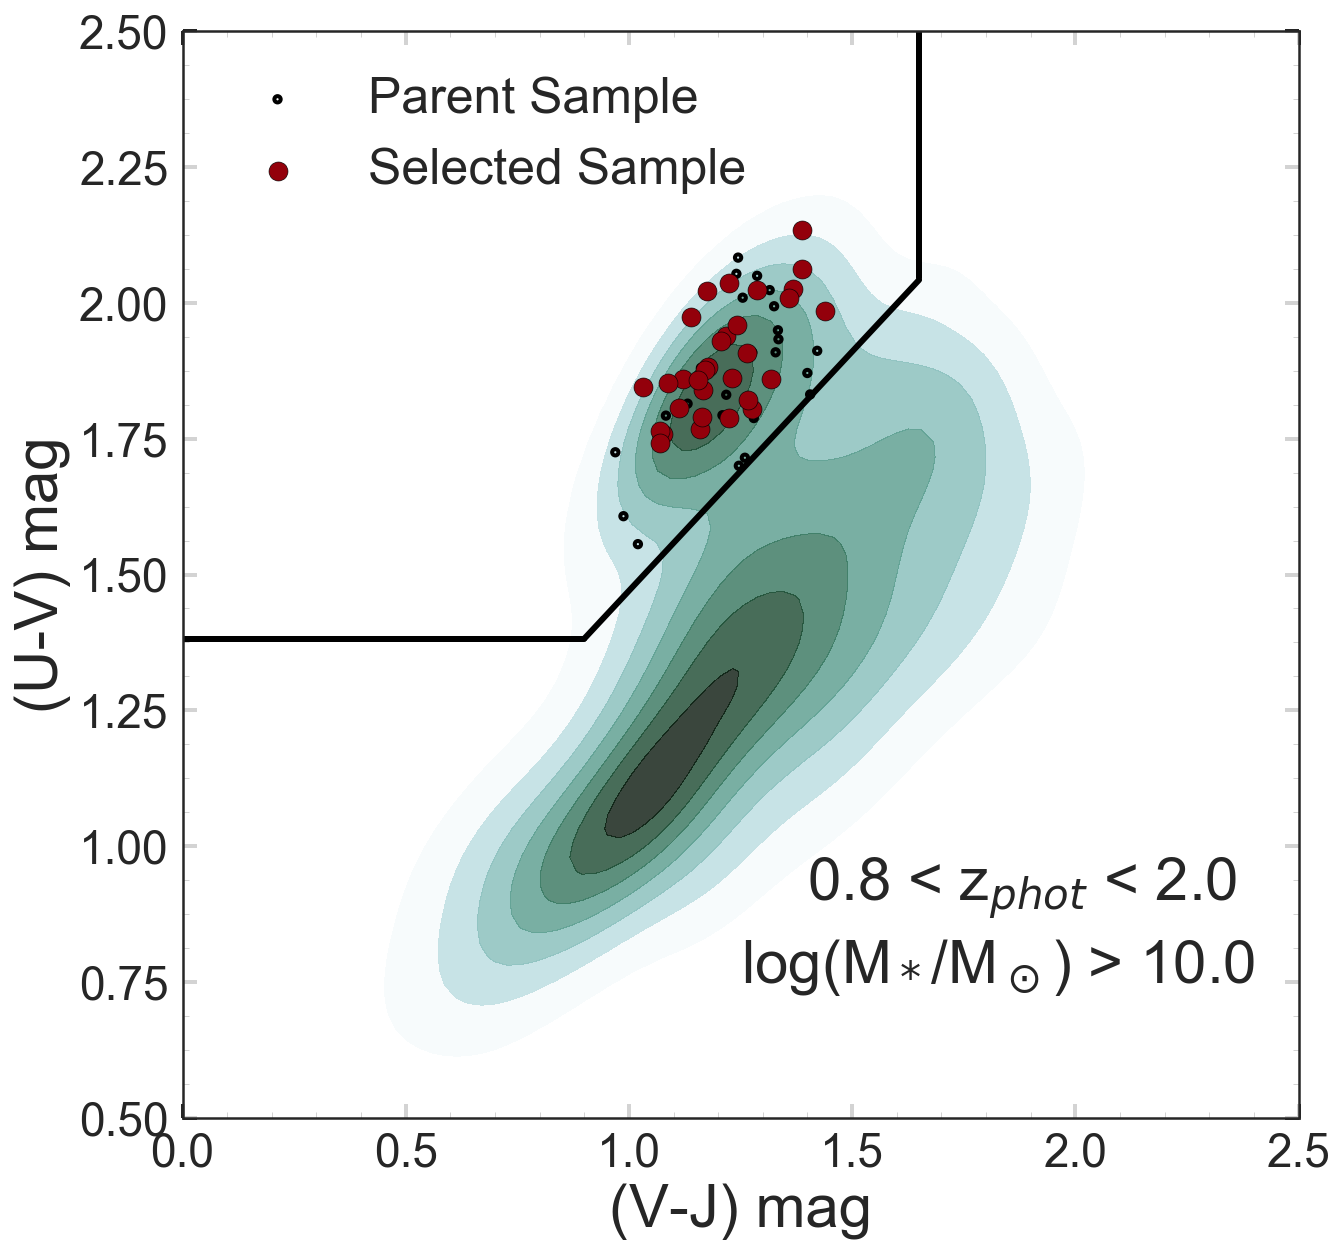

In [14]:
###PLOTS
%matplotlib inline

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.scatter(s_cand.query('goodspec == "out"').VJ,s_cand.query('goodspec == "out"').UV,
            marker='o', s=10,facecolors='none',edgecolors='k', linewidth=2, label = 'Parent Sample')
plt.scatter(n_cand.query('goodspec == "out"').VJ,n_cand.query('goodspec == "out"').UV.values,
            marker='o', s=10,facecolors='none',edgecolors='k', linewidth=2)

plt.scatter(s_cand.query('goodspec == "in"').VJ,s_cand.query('goodspec == "in"').UV,edgecolors='k',color='#93000B',s=90, label = 'Selected Sample')
plt.scatter(n_cand.query('goodspec == "in"').VJ,n_cand.query('goodspec == "in"').UV.values,edgecolors='k',color='#93000B',s=90)

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=25)
plt.text(1.4,0.90,'0.8 < z$_{phot}$ < 2.0', fontsize = 30)
plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.savefig('../plots/uvj_kde_plot.pdf',bbox_inches = 'tight')

In [58]:
all_S_list = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/*S*')
all_N_list = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/*N*')

In [59]:
SIDS=[]
NIDS=[]

for i in range(len(all_S_list)):
    SIDS.append(os.path.basename(all_S_list[i]).split('_')[-1])

for i in range(len(all_N_list)):
    if 'D' not in os.path.basename(all_N_list[i]):
        NIDS.append(os.path.basename(all_N_list[i]).split('_')[-1])

In [60]:
SIDS=np.array(list(set(SIDS))).astype(int)
NIDS=np.array(list(set(NIDS))).astype(int)

In [61]:
# goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
# goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

# if hpath == '/Users/Vince.ec/':
#     catpath = hpath
# else:
#     catpath='/Users/vestrada/Desktop/'

# restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
# restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

# fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
# fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

# eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
#                format = 'ascii').to_pandas()
# eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
#                format = 'ascii').to_pandas()

def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][SIDS-1].values) - Mag(restc_s['L155'][SIDS-1].values)
vjS=Mag(restc_s['L155'][SIDS-1].values) - Mag(restc_s['L161'][SIDS-1].values)
uvN=Mag(restc_n['L153'][NIDS-1].values) - Mag(restc_n['L155'][NIDS-1].values)
vjN=Mag(restc_n['L155'][NIDS-1].values) - Mag(restc_n['L161'][NIDS-1].values)
                    
Srshift_s = eazy_s.z_spec[SIDS-1]
Srshift_p = eazy_s.z_peak[SIDS-1]
Nrshift_s = eazy_n.z_spec[NIDS-1]
Nrshift_p = eazy_n.z_peak[NIDS-1]

In [62]:
s_cand = pd.DataFrame({'ids':SIDS, 'UV':uvS, 'VJ':vjS, 'zphot':Srshift_p, 'zspec':Srshift_s})
n_cand = pd.DataFrame({'ids':NIDS, 'UV':uvN, 'VJ':vjN, 'zphot':Nrshift_p, 'zspec':Nrshift_s})

In [63]:
s_AFspec = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s*')
n_AFspec = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/n*')

In [64]:
s_Aspec = [int(os.path.basename(U)[1:6]) for U in s_AFspec]
n_Aspec = [int(os.path.basename(U)[1:6]) for U in n_AFspec]

In [65]:
s_cand['allspec'] = np.repeat('out',len(s_cand))
n_cand['allspec'] = np.repeat('out',len(n_cand))

for i in s_cand.index:
    if s_cand.ids[i] in s_Aspec:
        s_cand.allspec[i] = 'in'
        
for i in n_cand.index:
    if n_cand.ids[i] in n_Aspec:
        n_cand.allspec[i] = 'in'

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [67]:
s_cand = s_cand.query("allspec == 'in'")
n_cand = n_cand.query("allspec == 'in'")

In [81]:
gFspec = galDB.gids.values

In [83]:
s_gspec = [int(os.path.basename(U)[1:6]) for U in s_gFspec]
n_gspec = [int(os.path.basename(U)[1:6]) for U in n_gFspec]

In [84]:
s_cand['goodspec'] = np.repeat('out',len(s_cand))
n_cand['goodspec'] = np.repeat('out',len(n_cand))

for i in s_cand.index:
    if s_cand.ids[i] in s_gspec:
        s_cand.goodspec[i] = 'in'
        
for i in n_cand.index:
    if n_cand.ids[i] in n_gspec:
        n_cand.goodspec[i] = 'in'

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Re

In [46]:
# s_cand.to_pickle('../data/S_allspec_info')
# n_cand.to_pickle('../data/N_allspec_info')

In [143]:
s_cand['l_mass'] = fast_s.lmass[s_cand.ids.values -1].values
n_cand['l_mass'] = fast_n.lmass[n_cand.ids.values -1].values

# Signal to Noise plot

In [7]:
s_cand = pd.read_pickle('../data/S_allspec_info')
n_cand = pd.read_pickle('../data/N_allspec_info')

In [8]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)


def SN(wv,fl,er):
    IDX = [U for U in range(len(wv)) if 8000 < wv[U] < 10500]
    return np.trapz(fl[IDX])/ Sig_int(er[IDX])

In [35]:
s_cand['SNR'] = np.zeros(len(s_cand))
n_cand['SNR'] = np.zeros(len(n_cand))

for i in s_cand.index:
    wv,fl,er = np.load('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s{0}.npy'.format(s_cand.ids[i]))
    s_cand['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])
        
for i in n_cand.index:
    wv,fl,er = np.load('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/n{0}.npy'.format(n_cand.ids[i]))
    n_cand['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [39]:
galDB['SNR'] = np.zeros(len(galDB))

for i in galDB.index:
    wv,fl,er = np.load('../spec_stacks/{0}.npy'.format(galDB.gids[i]))
    galDB['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


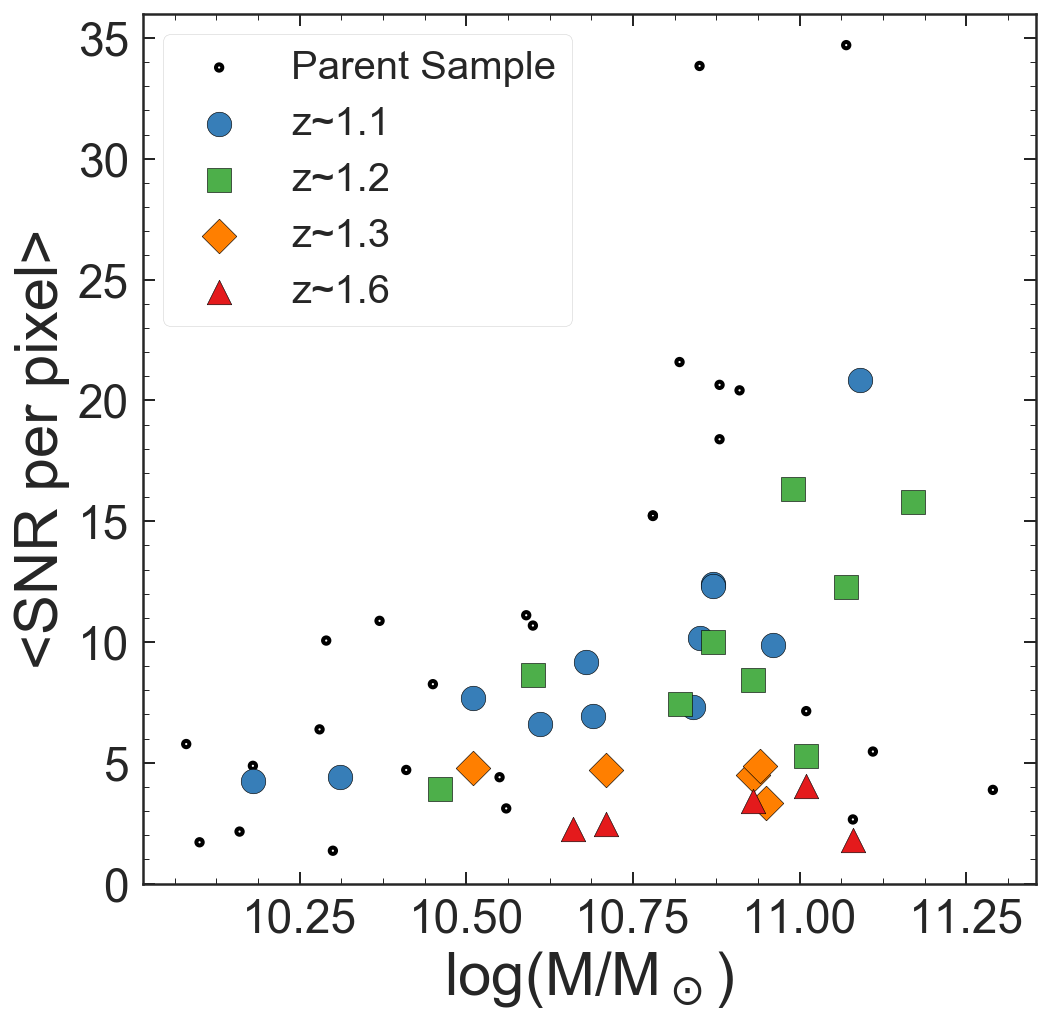

In [9]:
###PLOT
%matplotlib inline
#'#377eb8' '#4daf4a' '#ff7f00' '#e41a1c'
#'o','s','D','^'
plt.figure(figsize=[8,8])
plt.scatter(s_cand.query('goodspec == "out"')['l_mass'],s_cand.query('goodspec == "out"')['SNR'],marker='o', 
            s=10,facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Parent Sample')
plt.scatter(n_cand.query('goodspec == "out"')['l_mass'],n_cand.query('goodspec == "out"')['SNR'].values,marker='o', 
            s=10,facecolors='none',edgecolors='k', linewidth=2, zorder=0)
plt.scatter(lzDB['rf_lmass'],lzDB['SNR'],marker='o', s=150,edgecolors='k', color='#377eb8', label = 'z~1.1')
plt.scatter(mzDB['rf_lmass'],mzDB['SNR'],marker='s', s=150,edgecolors='k',color='#4daf4a', label = 'z~1.2')
plt.scatter(hzDB['rf_lmass'],hzDB['SNR'],marker='D', s=150,edgecolors='k',color='#ff7f00', label = 'z~1.3')
plt.scatter(uhzDB['rf_lmass'],uhzDB['SNR'],marker='^', s=150,edgecolors='k',color='#e41a1c', label = 'z~1.6')
plt.legend(loc=2,fontsize=20,frameon=True)
plt.xlabel('log(M/M$_\odot$)',fontsize=30)
plt.ylabel('<SNR per pixel>',fontsize=30)
plt.ylim(0,36)
# plt.axhline(3)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.savefig('../plots/sn_v_mass_8_13.png',bbox_inches = 'tight')

# flow chart plots

In [3]:
### Data
spec = Gen_spec(galDB['gids'][2], galDB['z_grism'][2],minwv=7900)
spec.Sim_spec(0.02,2.2,8.48)
wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.02_a2.2_dt8.48_spec.npy')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

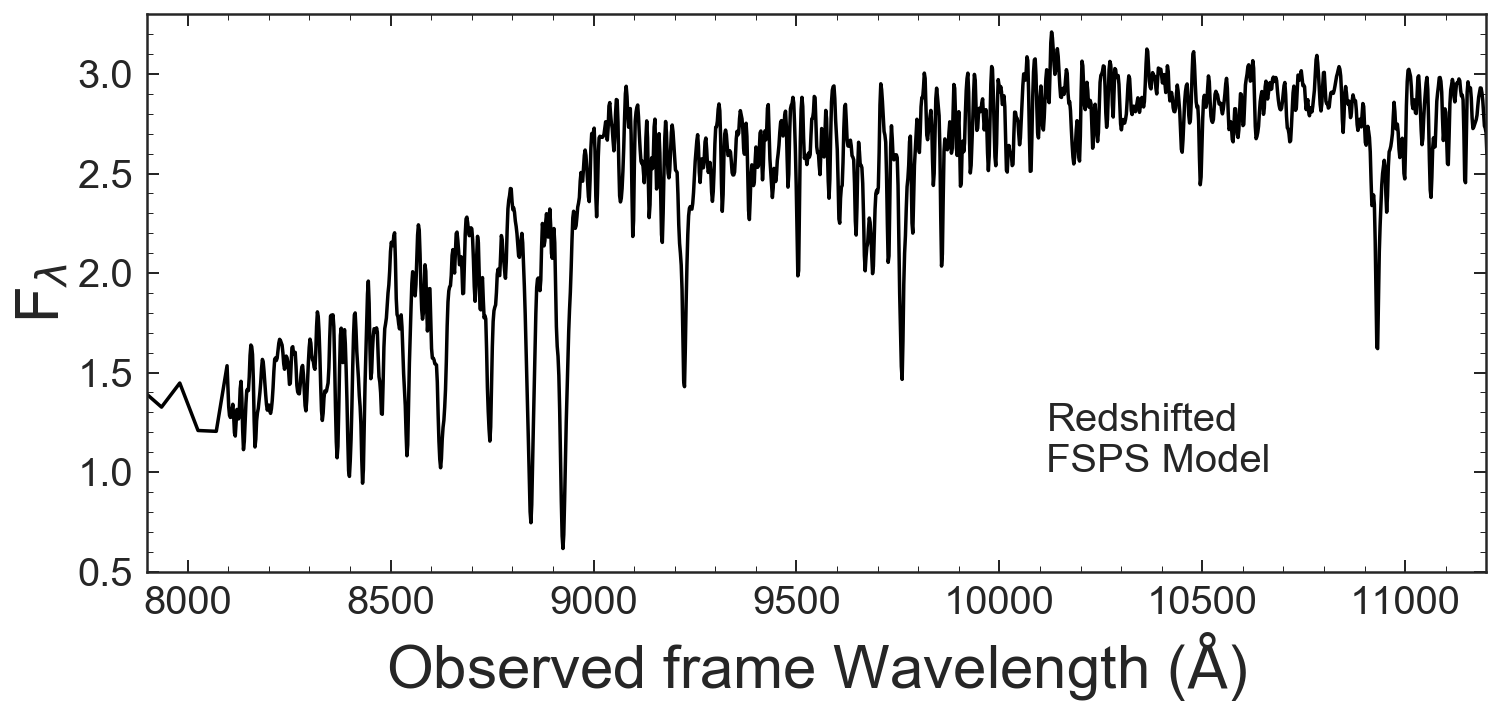

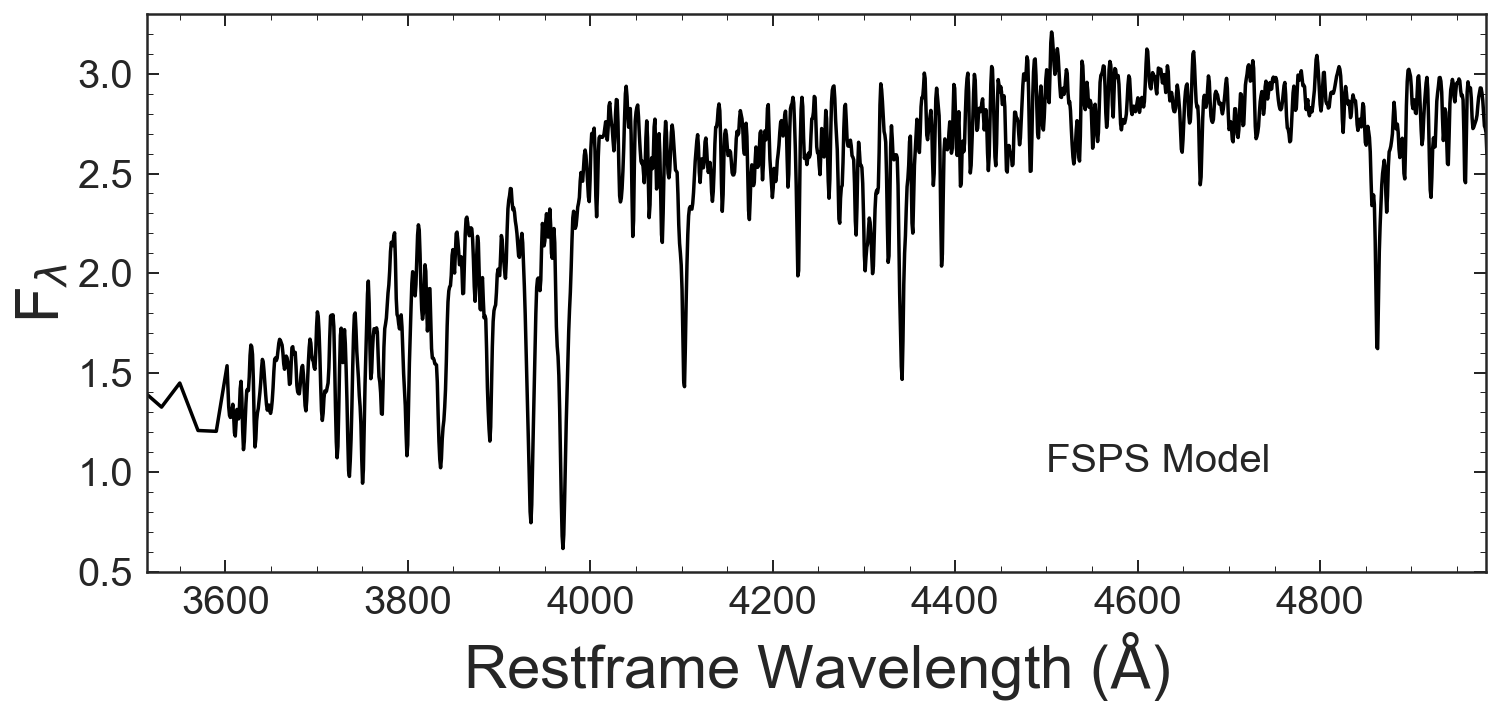

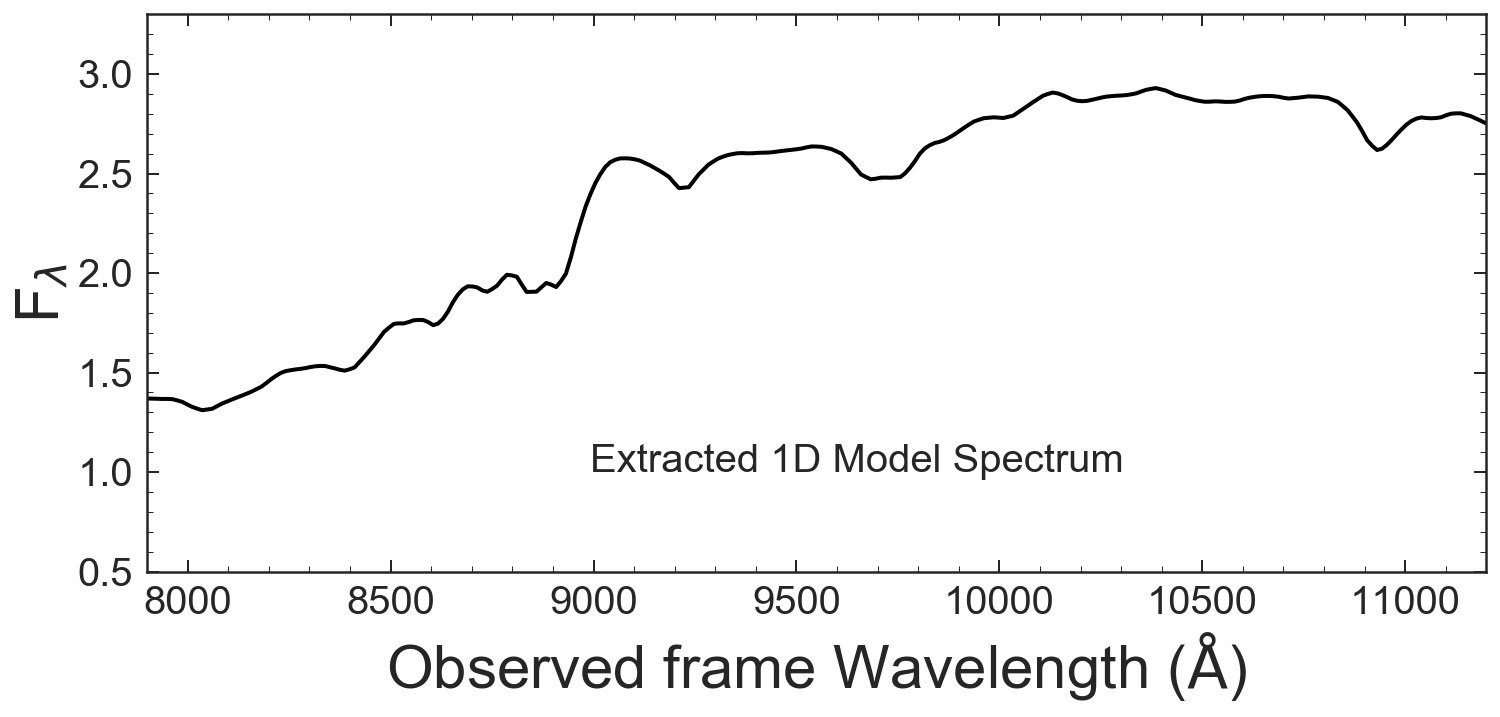

In [5]:
###PLOT###PLOT
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(wv * (1+galDB.z_grism[2]),fl*3.1E4, color='k')
plt.xlim(7900,11200)
plt.ylim(0.5,3.3)
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Observed frame Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500* (1+galDB.z_grism[2]),1,'Redshifted\nFSPS Model',fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/ex_fsps_9-3.png',bbox_inches = 'tight')


plt.figure(figsize=(12,6))
plt.plot(wv,fl*3.1E4, color='k')
plt.xlim(7900 / (1+galDB.z_grism[2]),11200 / (1+galDB.z_grism[2]))
plt.ylim(0.5,3.3)
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'FSPS Model',fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/ex_fsps_rf_9-3.png',bbox_inches = 'tight')


plt.figure(figsize=(12,6))
plt.plot(spec.gal_wv,spec.fl*1E18, color='k', linewidth=2)
plt.xlim(7900,11200)
plt.ylim(0.5,3.3)
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Observed frame Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4000* (1+galDB.z_grism[2]),1,'Extracted 1D Model Spectrum',fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/ex_grism_9-3.png',bbox_inches = 'tight')




(7900, 11200)

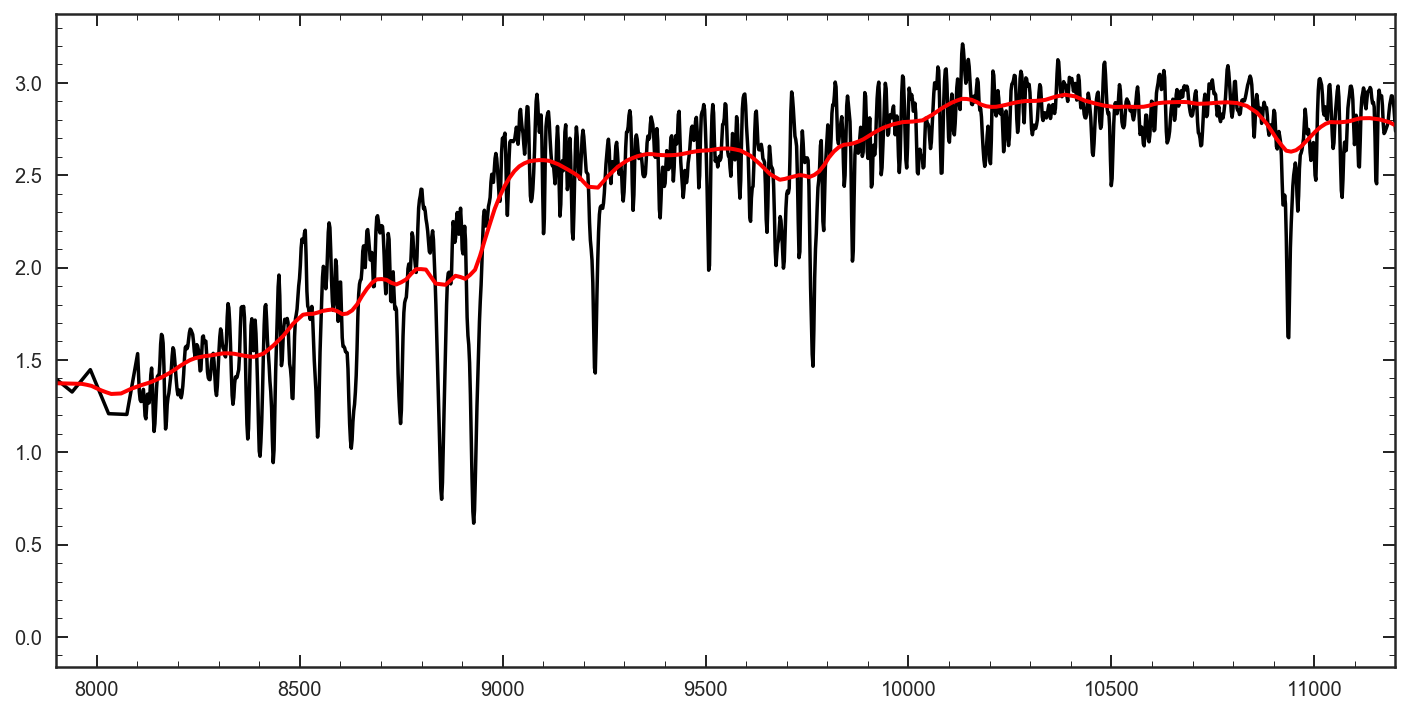

In [55]:
plt.figure(figsize=(12,6))
plt.plot(wv * (1+galDB.z_grism[2]),fl*3.1E4, color='k')

plt.plot(spec.gal_wv,spec.fl*1E18, color='r', linewidth=2)
plt.xlim(7900,11200)


# z$_{phot}$ v z$_{grism}$

In [170]:
s_cand['zgrism'] = np.zeros(len(s_cand))
n_cand['zgrism'] = np.zeros(len(n_cand))

for i in s_cand.index:
    if 's{0}'.format(s_cand.ids[i]) in galDB.gids.values:
        idx = 's{0}'.format(s_cand.ids[i])
        s_cand['zgrism'][i] = galDB.z_grism[galDB.gids == idx].values[0]
    else:
        z,Pz = np.load('../rshift_dat/s{0}_zfit_Pz.npy'.format(s_cand.ids[i]))
        s_cand['zgrism'][i] = z[Pz == max(Pz)][0]

for i in n_cand.index:
    try:
        if 'n{0}'.format(n_cand.ids[i]) in galDB.gids.values:
            idx = 'n{0}'.format(n_cand.ids[i])
            n_cand['zgrism'][i] = galDB.z_grism[galDB.gids == idx].values[0]
        else:
            z,Pz = np.load('../rshift_dat/n{0}_zfit_Pz.npy'.format(n_cand.ids[i]))
            n_cand['zgrism'][i] = z[Pz == max(Pz)][0]
    except:
        print('none')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

none
none


In [11]:
### Data
resS = (s_cand.query('goodspec == "in"')['zgrism'].values - s_cand.query('goodspec == "in"')['zphot'].values)
resN = (n_cand.query('goodspec == "in"')['zgrism'].values - n_cand.query('goodspec == "in"')['zphot'].values)

rejresS = (s_cand.query('goodspec == "out"')['zgrism'].values - s_cand.query('goodspec == "out"')['zphot'].values)
rejresN = (n_cand.query('goodspec == "out"')['zgrism'].values - n_cand.query('goodspec == "out"')['zphot'].values)

mres = np.percentile(np.append(resS,resN),50)
lres = np.percentile(np.append(resS,resN),16)
hres = np.percentile(np.append(resS,resN),84)

zs= np.append(s_cand.query('goodspec == "in"')['zgrism'].values,n_cand.query('goodspec == "in"')['zgrism'].values)
rejzs= np.append(s_cand.query('goodspec == "out"')['zgrism'].values,n_cand.query('goodspec == "out"')['zgrism'].values)
res = np.append(resS,resN)
rejres = np.append(rejresS,rejresN)

In [178]:
n_cand.query('goodspec == "out"')['zgrism'].values

array([1.087, 0.933, 0.932, 0.   , 0.934, 0.94 , 0.849, 0.908, 1.252,
       0.   , 0.854, 0.932, 0.965, 0.932, 0.926, 1.875, 0.94 ])

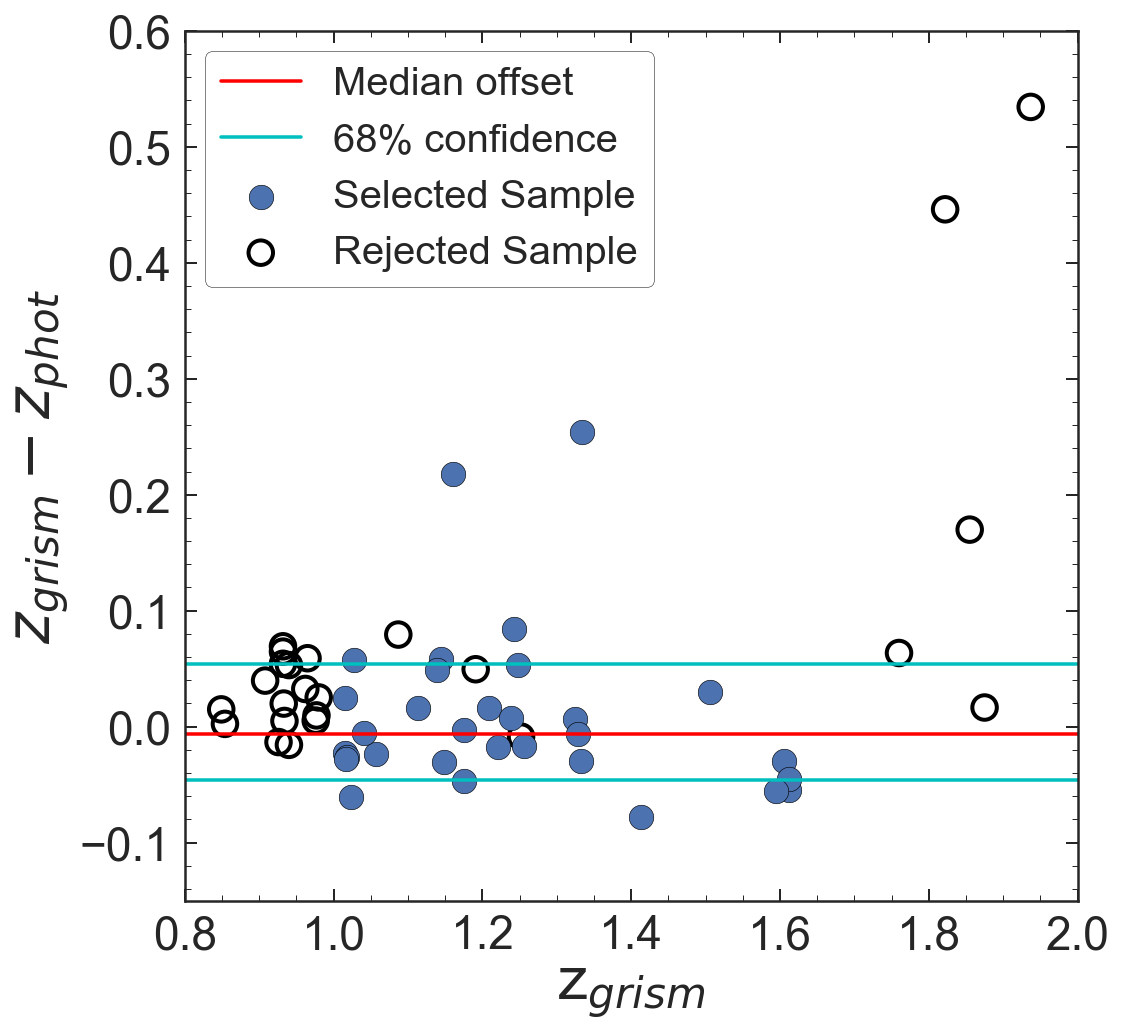

In [12]:
### PLOT 

plt.figure(figsize=[8,8])
plt.scatter(zs,list(res),marker='o', s=150,edgecolors='k',label = 'Selected Sample')
plt.scatter(rejzs,rejres,marker='o',s=150,
            facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Rejected Sample')

plt.axhline(mres,color='r',label = 'Median offset')
plt.axhline(lres,color='c',label = '68% confidence')
plt.axhline(hres,color='c')
plt.xlim(.8,2.0)
plt.ylim(-.15,.6)
plt.ylabel('$z_{grism} - z_{phot}$',fontsize=30)
plt.xlabel('z$_{grism}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(loc=2,fontsize=20,frameon=True,edgecolor='k')
plt.minorticks_on()
plt.savefig('../plots/redshift_diff_8_13.png',bbox_inches = 'tight')

# Example spec and LH

In [13]:
### Data
spec = Gen_spec(galDB.gids[2], galDB.z_grism[2],minwv=7800,maxwv=11100)
spec.Fit_lwa(galDB.Z[2],galDB.t[2],galDB.z_grism[2],galDB.d[2],metal,age,tau)
P = np.load('../chidat/n21156_full_fit_tZ_pos.npy')
t,Pt = np.load('../chidat/n21156_full_fit_t_pos.npy')
Z,PZ = np.load('../chidat/n21156_full_fit_Z_pos.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


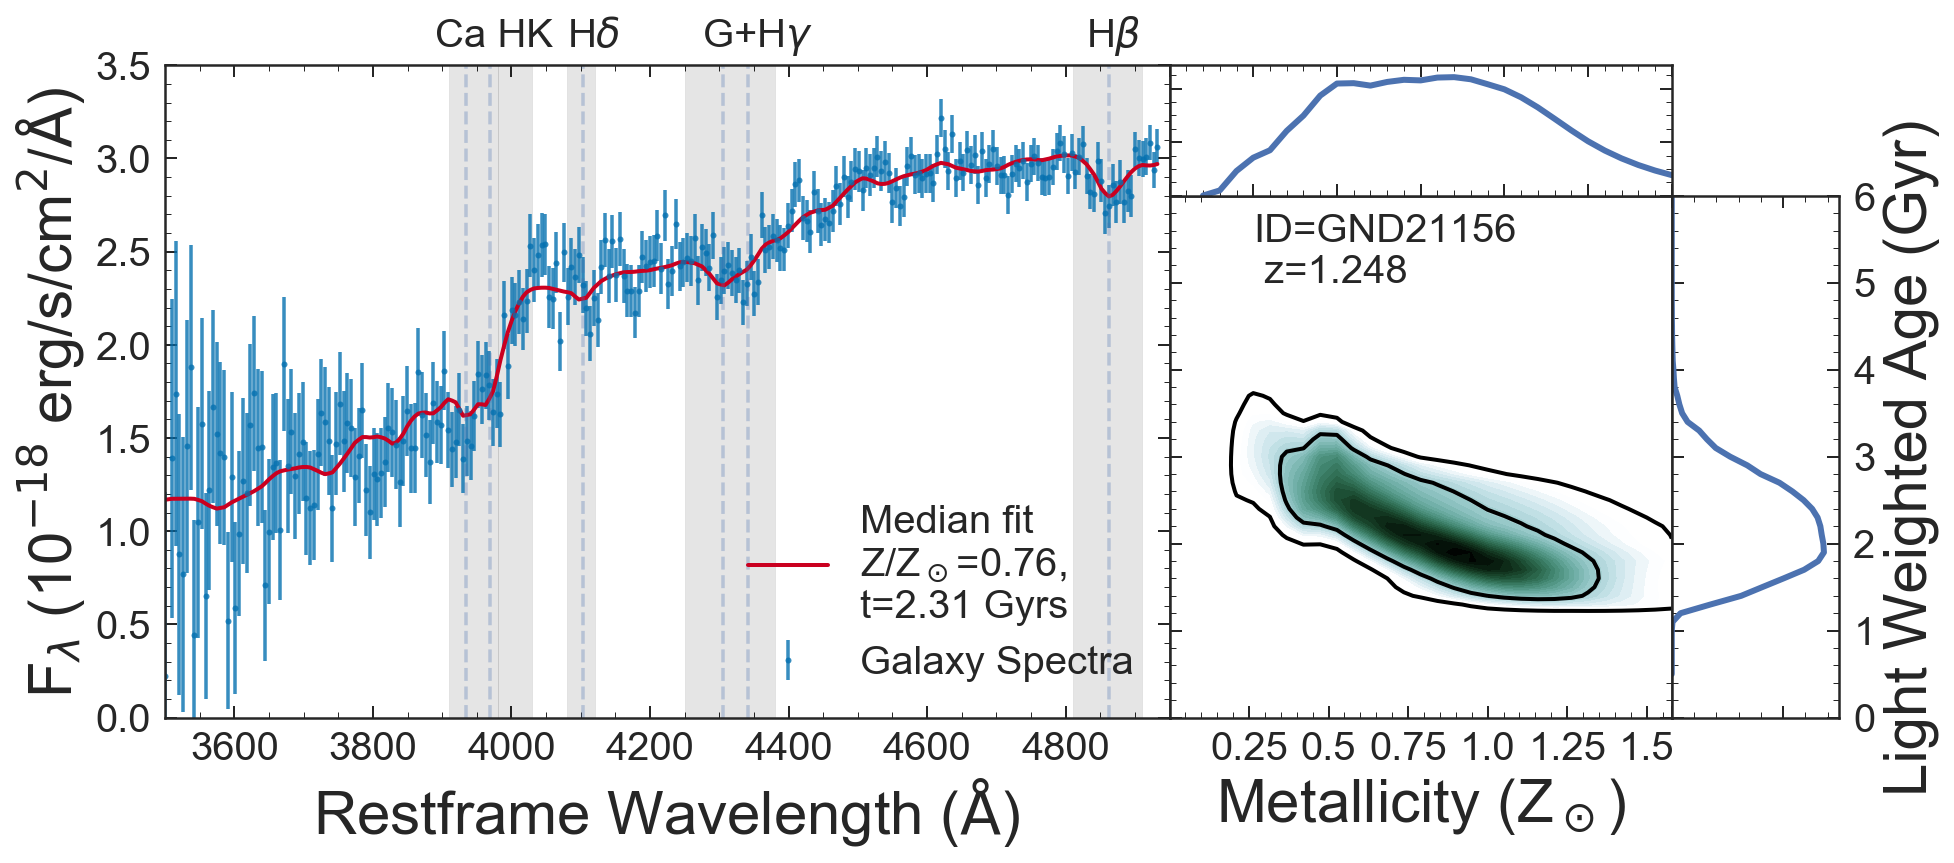

In [14]:
### Plot
%matplotlib inline

gs = gridspec.GridSpec(2,3,height_ratios=[1,4],width_ratios=[6,3,1],hspace=0,wspace=0)

plt.figure(figsize=(15,6))
plt.subplot(gs[0:2,0])
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.o_er*1E18,color='#0571b0', alpha = 0.8,
             linestyle='None', marker='o', markersize=3,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020', linewidth=2,
         label='Median fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Zx'][2]/0.019,2),
                                                           np.round(galDB['tx'][2],2)))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3890,3.6,'Ca HK',fontsize=20)
plt.text(4080,3.6,'H$\delta$',fontsize=20)
plt.text(4275,3.6,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=20)
plt.xlim(3500,4950)
plt.ylim(0,3.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,1])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=30)
# plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.text(.005,5,'ID=GND21156\n z=1.248', fontsize=20)

plt.subplot(gs[0,1])
plt.plot(Z,PZ,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.xlim(0,0.03)
plt.ylim(0,max(PZ)*1.1)

ax = plt.subplot(gs[1,2])
plt.plot(Pt,t,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
plt.ylabel('Light Weighted Age (Gyr)',size=30)
ax.yaxis.set_label_position("right")
plt.gca().tick_params(axis='x',labelbottom='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(0,6)
plt.xlim(0,max(Pt)*1.1)
plt.savefig('../plots/n21156_bf_lh_8_13.png',bbox_inches = 'tight')


# Age vs Redshift

In [3]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/{0}_full_fit_{1}_pos.npy'.format(DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [16]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

ferrdb = pd.read_pickle('../data/Q_ferreras.pkl')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl,Px = Iterative_stacking(Pl_grid,age)
Pm,Px = Iterative_stacking(Pm_grid,age)
Ph,Px = Iterative_stacking(Ph_grid,age)
Puh,Px = Iterative_stacking(Puh_grid,age)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

lt=np.array(lzDB['tx'])
mt=np.array(mzDB['tx'])
ht=np.array(hzDB['tx'])
uht=np.array(uhzDB['tx'])
# gmtlt=np.array(gmtlDB['tx'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
####200-mean
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in subtract
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in add


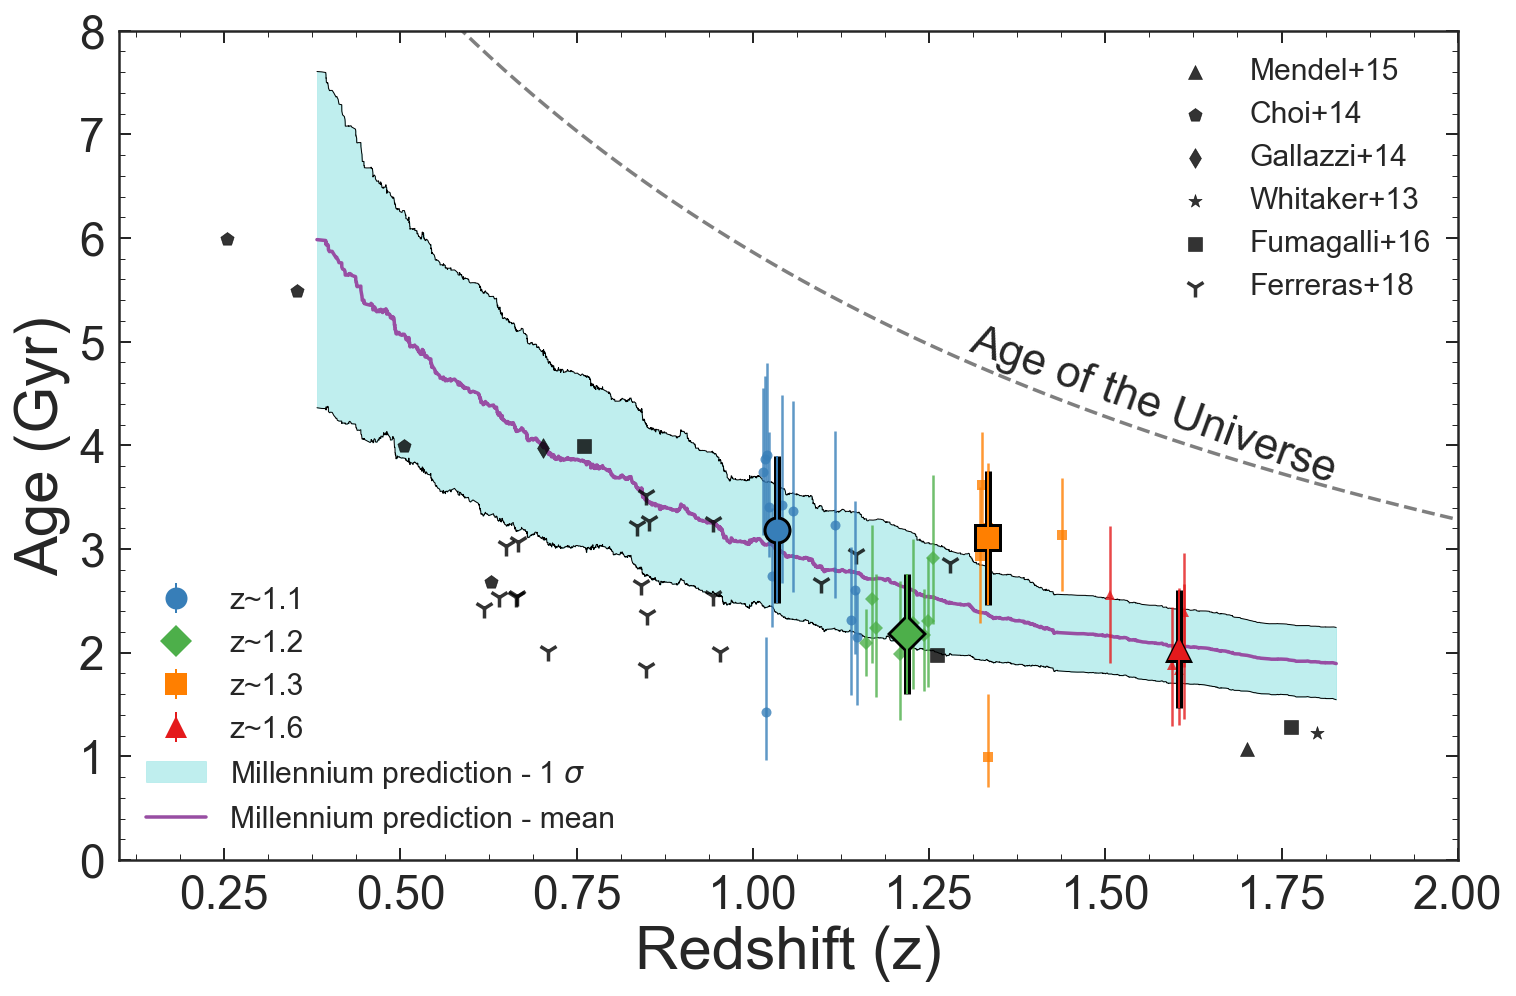

In [17]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^',zorder=2,alpha=0.8)         
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p',zorder=2,alpha=0.8) 
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d',zorder=2,alpha=0.8)       
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*',zorder=2,alpha=0.8)       
ax5=plt.scatter(fumx[6:9],fumy[6:9],color='k',zorder=2,marker='s',alpha=0.8)
ax6=plt.scatter(ferrdb['z'],ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,alpha=0.8)

###allpoints
plt.errorbar(lzDB['z_grism'],lt,yerr=[lzDB['tx_l'],lzDB['tx_h']],
             color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o',zorder=3)
plt.errorbar(mzDB['z_grism'],mt,yerr=[mzDB['tx_l'],mzDB['tx_h']],
             color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D',zorder=3)
plt.errorbar(hzDB['z_grism'],ht,yerr=[hzDB['tx_l'],hzDB['tx_h']],
             color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s',zorder=3)
plt.errorbar(uhzDB['z_grism'],uht,yerr=[uhzDB['tx_l'],uhzDB['tx_h']],
             color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^',zorder=3)

####edge
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color='k',elinewidth=3.5,ms=14,fmt='o',zorder=4)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='k',elinewidth=3.5,ms=14,fmt='D',zorder=4)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='k',elinewidth=3.5,ms=14,fmt='s',zorder=4)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=3.5,ms=14,fmt='^',zorder=4)

####face
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color ='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1',zorder=5)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2',zorder=5)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3',zorder=5)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6',zorder=5)

#### millenium
plt.plot(z_g[IDW],rmean,color = '#984ea3',zorder=1,label = 'Millennium prediction - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5,zorder=1)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5,zorder=1)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium prediction - 1 $\sigma$',zorder=1)

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([2,3,4,5,1,0])

plt.axis([0.1,2.0,0,8])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5,ax6],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16','Ferreras+18'],
              fontsize=15)
plt.legend(handles[IDX], labels[IDX],loc = 3, fontsize=15)
currentAxis.add_artist(l1)
plt.savefig('../plots/agevz_featgroup_all_dt_8_13.png',bbox_inches = 'tight')




/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


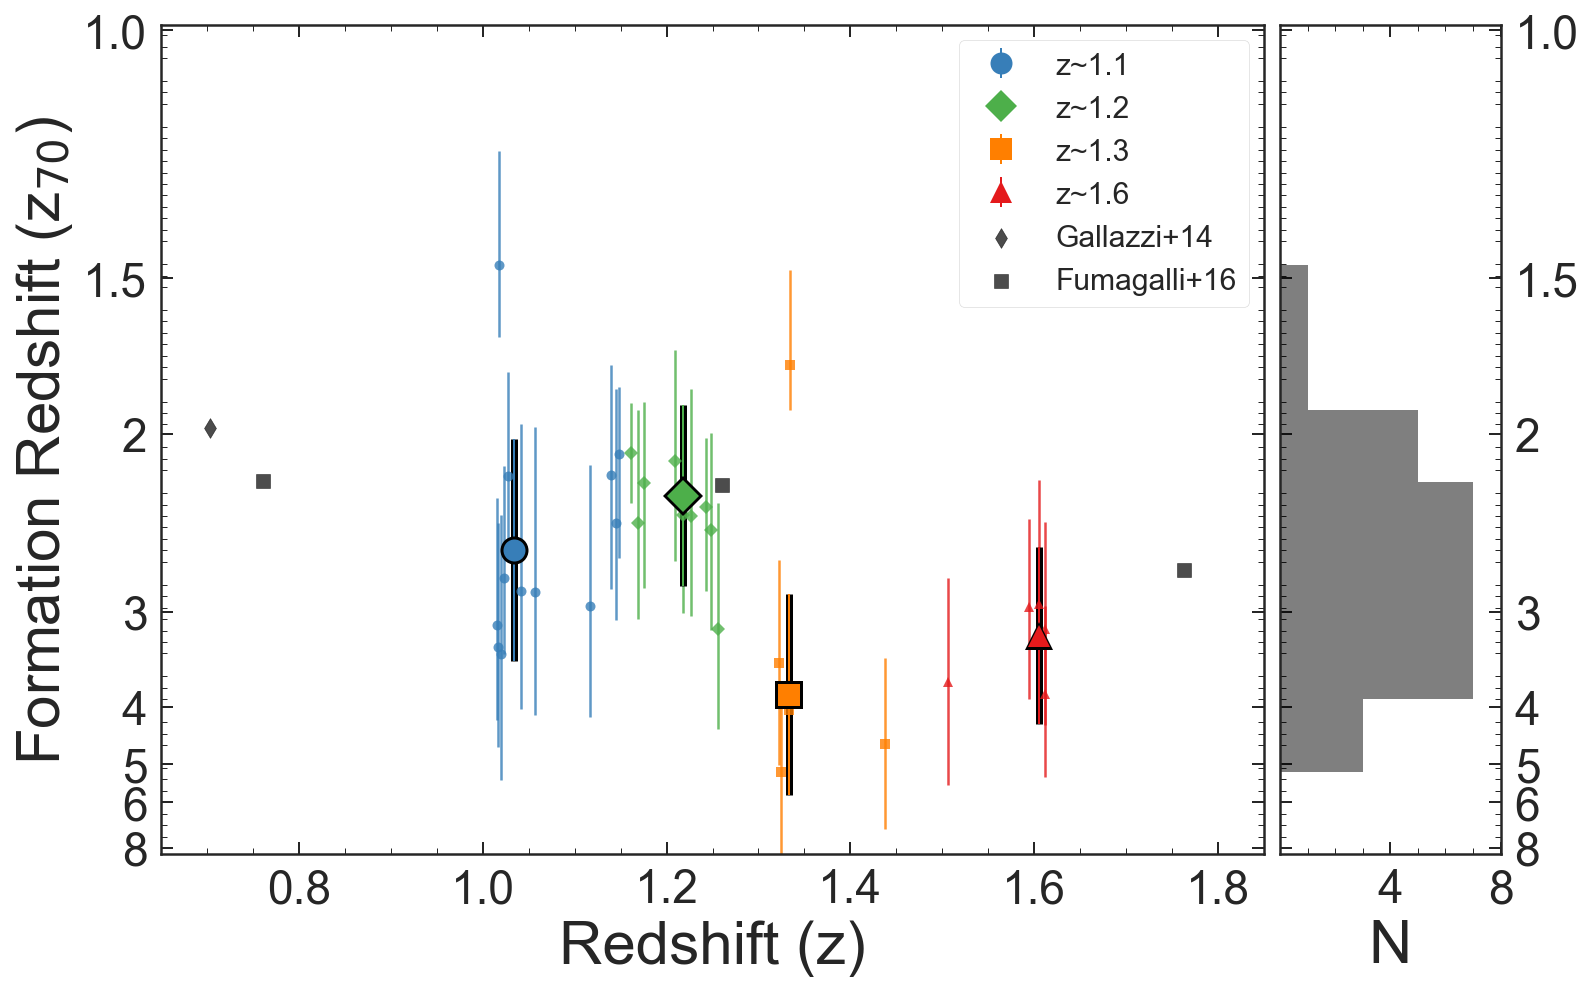

In [18]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

gs = gridspec.GridSpec(1,2,wspace=0.025,width_ratios=[5,1])

plt.figure(figsize=[12,8])
plt.subplot(gs[0])
currentAxis = plt.gca()

plt.scatter(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],color = 'k',marker='d',label='Gallazzi+14',alpha=0.7)
plt.scatter(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],color='k',zorder=2,marker='s',label='Fumagalli+16',alpha=0.7)

plt.errorbar(lzDB['z_grism'], Oldest_galaxy(lzDB['z_grism']) - lt,
             yerr=[lzDB['tx_l'],lzDB['tx_h']],color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['z_grism'],Oldest_galaxy(mzDB['z_grism']) - mt,
             yerr=[mzDB['tx_l'],mzDB['tx_h']],color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['z_grism'],Oldest_galaxy(hzDB['z_grism']) - ht,
             yerr=[hzDB['tx_l'],hzDB['tx_h']],color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['z_grism'],Oldest_galaxy(uhzDB['z_grism']) - uht,
             yerr=[uhzDB['tx_l'],uhzDB['tx_h']],color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^')

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='k',fmt='o',elinewidth=3.5,ms=14)
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='k',fmt='D',elinewidth=3.5,ms=14)
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='k',fmt='s',elinewidth=3.5,ms=14)
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',fmt='^',elinewidth=3.5,ms=14)

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# plt.axhline(2.58)
# plt.axhline(2.36,color='r')

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([2,3,4,5,0,1])

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.xlim(.65,1.85)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.ylim(0.6,5.9)
plt.legend(handles[IDX], labels[IDX],fontsize=15,frameon=True)

plt.subplot(gs[1])
sea.distplot(Oldest_galaxy(galDB['z_grism'].values) - galDB.tx.values,bins=7,vertical=True,kde=False,
             hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k',"label":'This Work'})

# plt.ylim(-1.31,.5)
plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
plt.xticks([4,8])
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.ylim(0.6,5.9)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.xlabel('N',size=30)
# plt.legend(fontsize=15)

plt.savefig('../plots/agevz_rshift_all_dt_8_13.png',bbox_inches = 'tight')

In [6]:
np.mean(Oldest_galaxy(galDB['z_grism'].values) - galDB.tx.values)*3.49*31**(-1/3.)

2.802815220382341

In [183]:
np.median(Oldest_galaxy(galDB['z_grism']) - galDB['tx'])

2.3611732060898096

In [192]:
print(Oldest_galaxy(0) * u.Gyr -Planck13.lookback_time(2.5))

2.6186670380200656 Gyr


# Mass Metallicity

In [19]:
"""DATA"""
gmtlDB = galDB

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl,Px = Iterative_stacking(Pl_grid,metal,extend=True)
Pm,Px = Iterative_stacking(Pm_grid,metal,extend=True)
Ph,Px = Iterative_stacking(Ph_grid,metal,extend=True)
Puh,Px = Iterative_stacking(Puh_grid,metal,extend=True)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx'])
mZ=np.array(mzDB['Zx'])
hZ=np.array(hzDB['Zx'])
uhZ=np.array(uhzDB['Zx'])
gmtlZ=np.array(gmtlDB['Zx'])

lerrs = gmtlDB['Zx_l']/(gmtlDB['Zx'] * np.log(10))
herrs = gmtlDB['Zx_h']/(gmtlDB['Zx'] * np.log(10))
errs = ((gmtlDB['Zx_l'] + gmtlDB['Zx_h'])/2) / (gmtlDB['Zx'] * np.log(10))
samp = np.arange(.9,11.9,.01)
lfit,lfit_errs,cov = Linear_fit(gmtlDB['rf_lmass'],np.log10(gmtlZ/0.019),errs,samp,return_cov=True)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


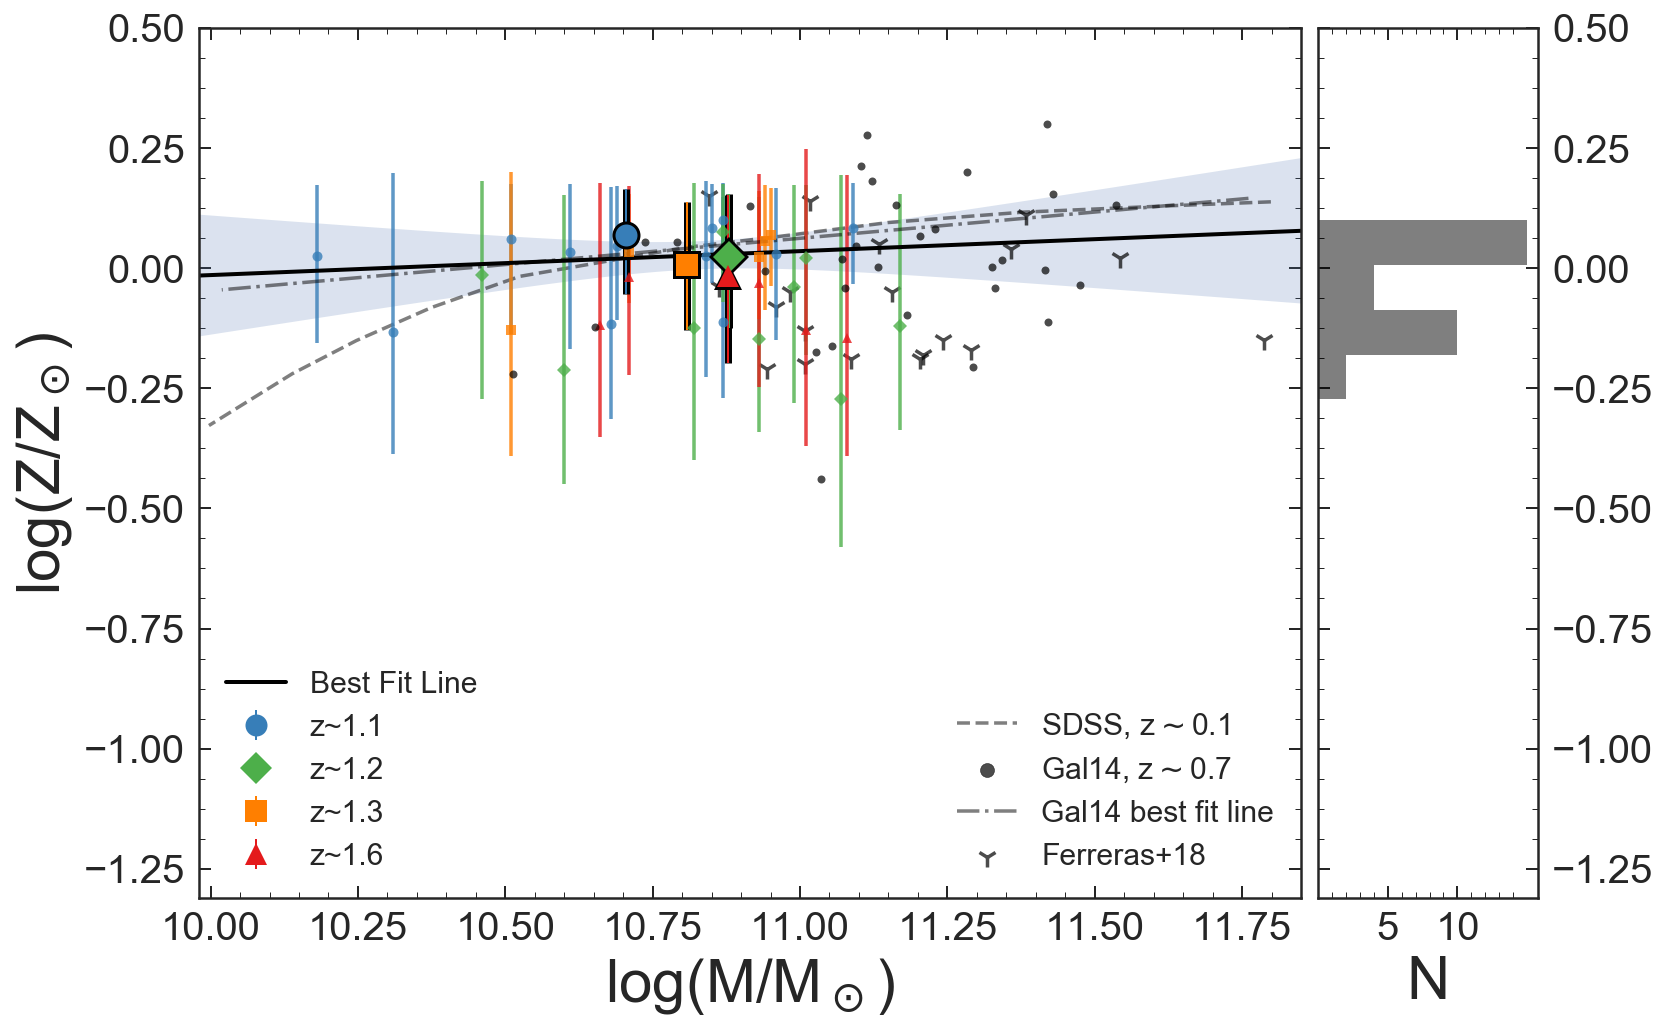

In [20]:
###PLOT
%matplotlib inline

gs = gridspec.GridSpec(1,2,wspace=0.025,width_ratios=[5,1])

plt.figure(figsize=[12,8])

####gallazzi points
plt.subplot(gs[0])
currentAxis = plt.gca()

plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.5,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.7,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.7)#,label='Gallazzi+14,z=0.7')
#####ferreras points
ferra = plt.scatter(np.log10(ferrdb['M']*1E11),ferrdb['Z/H'].values,color='k',zorder=2,marker='1',alpha=.7,s=100,label='Ferreras+18')
legend1 = plt.legend([sdss,galpts,galbf,ferra],
                     ['SDSS, z$\sim$0.1','Gal14, z$\sim$0.7','Gal14 best fit line','Ferreras+18'],
                     loc = 4,fontsize=15)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['rf_lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_l']/(lzDB['Zx'] * np.log(10)),
            lzDB['Zx_h']/(lzDB['Zx'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['rf_lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_l']/(mzDB['Zx'] * np.log(10)),
            mzDB['Zx_h']/(mzDB['Zx'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['rf_lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_l']/(hzDB['Zx'] * np.log(10)),
            hzDB['Zx_h']/(hzDB['Zx'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['rf_lmass'],np.log10(uhZ/0.019), yerr=[uhzDB['Zx_l']/(uhzDB['Zx'] * np.log(10)),
            uhzDB['Zx_h']/(uhzDB['Zx'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^')

### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


#### edge
plt.errorbar(np.mean(lzDB['rf_lmass']),np.log10(lmed/0.019), 
             yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],color='k',ms=14,fmt='o',elinewidth=3.5)
plt.errorbar(np.mean(mzDB['rf_lmass']),np.log10(mmed/0.019),  
             yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],color='k',ms=14,fmt='D',elinewidth=3.5)
plt.errorbar(np.mean(hzDB['rf_lmass']),np.log10(hmed/0.019),  
             yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],color='k',ms=14,fmt='s',elinewidth=3.5)
plt.errorbar(np.mean(uhzDB['rf_lmass']),np.log10(uhmed/0.019),  
             yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],color='k',ms=14,fmt='^',elinewidth=3.5)
#### face
plt.errorbar(np.mean(lzDB['rf_lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.mean(mzDB['rf_lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.mean(hzDB['rf_lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.mean(uhzDB['rf_lmass']),np.log10(uhmed/0.019),  yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# plt.plot(samp,0.1616*samp11 + 0.0867,'r')

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([0,3,4,5,6])

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([9.98,11.85,-1.31,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
currentAxis.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
# plt.minorticks_on()
# plt.plot(samp,0.15188174999999998*samp11 + 0.0754834 ,'r')

plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)

plt.subplot(gs[1])
sea.distplot(np.log10(galDB.Zx.values/0.019),vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k',"label":'This Work'})

plt.ylim(-1.31,.5)
plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
plt.xticks([5,10])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('N',size=30)
# plt.legend(fontsize=15)

plt.savefig('../plots/metalmass_featgroup_8_13.png',bbox_inches = 'tight')

In [64]:
np.arange(10.00,11.8,.25)

array([10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75])

In [9]:
log11=(np.log10(10**gmtlDB['l_mass'].values / 10**11))
samp11 = (np.log10(10**samp / 10**11))


In [10]:
Linear_fit(log11,np.log10(gmtlZ/0.019),errs,np.array([0,1,2]),return_cov=True)

(array([0.0754834 , 0.22736515, 0.3792469 ]),
 array([0.03030705, 0.14538599, 0.27048468]),
 array([[0.00091852, 0.00215771],
        [0.00215771, 0.01590315]]))

In [16]:
0.22736515-0.0754834

0.15188174999999998

In [26]:
print('$\sigma_b = {0}$'.format(np.sqrt(0.00091852)))
print('$\sigma_m = {0}$'.format(np.sqrt(0.01590315)))



$\sigma_b = 0.030307094878922327$
$\sigma_m = 0.1261076920730849$


# Stacks

In [13]:
3.3 \pm 0.7
2.2 \pm 0.6
3.1 \pm 0.6
2.0 \pm 0.6

9.954242509439325

In [ ]:
\zone &$1.17_{-0.33}^{+0.26}$ & $3.2 \pm 0.7$ & 10.1--11.1  & 12\\
\ztwo &$1.05_{-0.36}^{+0.32}$&$2.2 \pm 0.6$   & 10.6--11.2 & 9\\
\zthree &$1.01_{-0.31}^{+0.31}$&$3.1 \pm 0.6$ & 10.5--11.0 & 5 \\
\zsix &$0.96_{-0.40}^{+0.38}$&$2.0 \pm 0.6$  & 10.7--11.1 & 5\\

In [37]:
med,l,h = Median_w_Error(PZuh,metal)
print(np.array([med,l,h])/ 0.019)

[1.         0.42105263 0.31578947]


In [4]:
"""DATA"""

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PDl_grid = Gen_grid(lzDB,'d')
PDm_grid = Gen_grid(mzDB,'d')
PDh_grid = Gen_grid(hzDB,'d')
PDuh_grid = Gen_grid(uhzDB,'d')

PZl,wPZl = Iterative_stacking(PZl_grid,metal,extend=True)
PZm,wPZm = Iterative_stacking(PZm_grid,metal,extend=True)
PZh,wPZh = Iterative_stacking(PZh_grid,metal,extend=True)
PZuh,wPZuh = Iterative_stacking(PZuh_grid,metal,extend=True)

PTl,wPTl = Iterative_stacking(PTl_grid,age)
PTm,wPTm = Iterative_stacking(PTm_grid,age)
PTh,wPTh = Iterative_stacking(PTh_grid,age)
PTuh,wPTuh = Iterative_stacking(PTuh_grid,age)

PDl,PDx = Iterative_stacking(PDl_grid,dust)
PDm,PDx = Iterative_stacking(PDm_grid,dust)
PDh,PDx = Iterative_stacking(PDh_grid,dust)
PDuh,PDx = Iterative_stacking(PDuh_grid,dust)

Zmedl, Zler, Zher = Median_w_Error(PZl,metal)
Zmedm, Zler, Zher = Median_w_Error(PZm,metal)
Zmedh, Zler, Zher = Median_w_Error(PZh,metal)
Zmeduh, Zler, Zher = Median_w_Error(PZuh,metal)
tmedl, tler, ther = Median_w_Error(PTl,age)
tmedm, tler, ther = Median_w_Error(PTm,age)
tmedh, tler, ther = Median_w_Error(PTh,age)
tmeduh, tler, ther = Median_w_Error(PTuh,age)
dmedl, dler, dher = Median_w_Error(PDl,dust)
dmedm, dler, dher = Median_w_Error(PDm,dust)
dmedh, dler, dher = Median_w_Error(PDh,dust)
dmeduh, dler, dher = Median_w_Error(PDuh,dust)

lzstack = Stack(lzDB['gids'].values,lzDB['z_grism'].values,np.arange(3400,5500,10),np.arange(4000,5200,1))
lzstack.Stack_normwmean()
lzstack.Fit_lwa(Zmedl,tmedl,dmedl,metal,age,tau)

mzstack = Stack(mzDB['gids'].values,mzDB['z_grism'].values,np.arange(3400,5300,10),np.arange(3750,4750,1))
mzstack.Stack_normwmean()
mzstack.Fit_lwa(Zmedm,tmedm,dmedm,metal,age,tau)

hzstack = Stack(hzDB['gids'].values,hzDB['z_grism'].values,np.arange(3350,5300,10),np.arange(3475,4550,1))
hzstack.Stack_normwmean()
hzstack.Fit_lwa(Zmedh,tmedh,dmedh,metal,age,tau)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['z_grism'].values,np.arange(3075,4450,10),np.arange(3400,4200,1))
uhzstack.Stack_normwmean()
uhzstack.Fit_lwa(Zmeduh,tmeduh,dmeduh,metal,age,tau)


/Users/Vince.ec/GitHub/Quiescent_analysis/scripts/spec_id.py:2618: RuntimeWarning: divide by zero encountered in log10
  rto = int(np.abs(min(np.log10(x_o)[np.abs(np.log10(x_o)) != np.inf])))+1
/Users/Vince.ec/GitHub/Quiescent_analysis/scripts/spec_id.py:242: RuntimeWarning: divide by zero encountered in log10
  power = int(np.abs(min(np.log10(x)[np.abs(np.log10(x)) != np.inf])))+1
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.

In [160]:
min(np.log10(dust)[np.abs(np.log10(dust)) != np.inf])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-1.0

In [5]:
"""PLOT"""
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,A,mdist,M,wadist,wmdist,window=[],group='',group_win=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(group_win[0],group_win[1],group,fontsize=25,backgroundcolor=[.3,.3,.3],color='w')
  
    if window[1] > 4250:
        plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    ax = plt.subplot(gs[0,1])
    plt.plot(age,wadist,label = 'P$^*$(t)',color='#377eb8',linewidth=3)
    plt.plot(A,adist,label = 'P(t)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xlim(min(age),max(age))
    plt.ylim(0,max(adist)*1.1)
    plt.xlabel('Age (Gyr)',size=20)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,wmdist,label = 'P$^*$(Z)',color='#377eb8',linewidth=3)
    plt.plot(M,mdist,label = 'P(Z)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.ylim(0,max(mdist)*1.1)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')

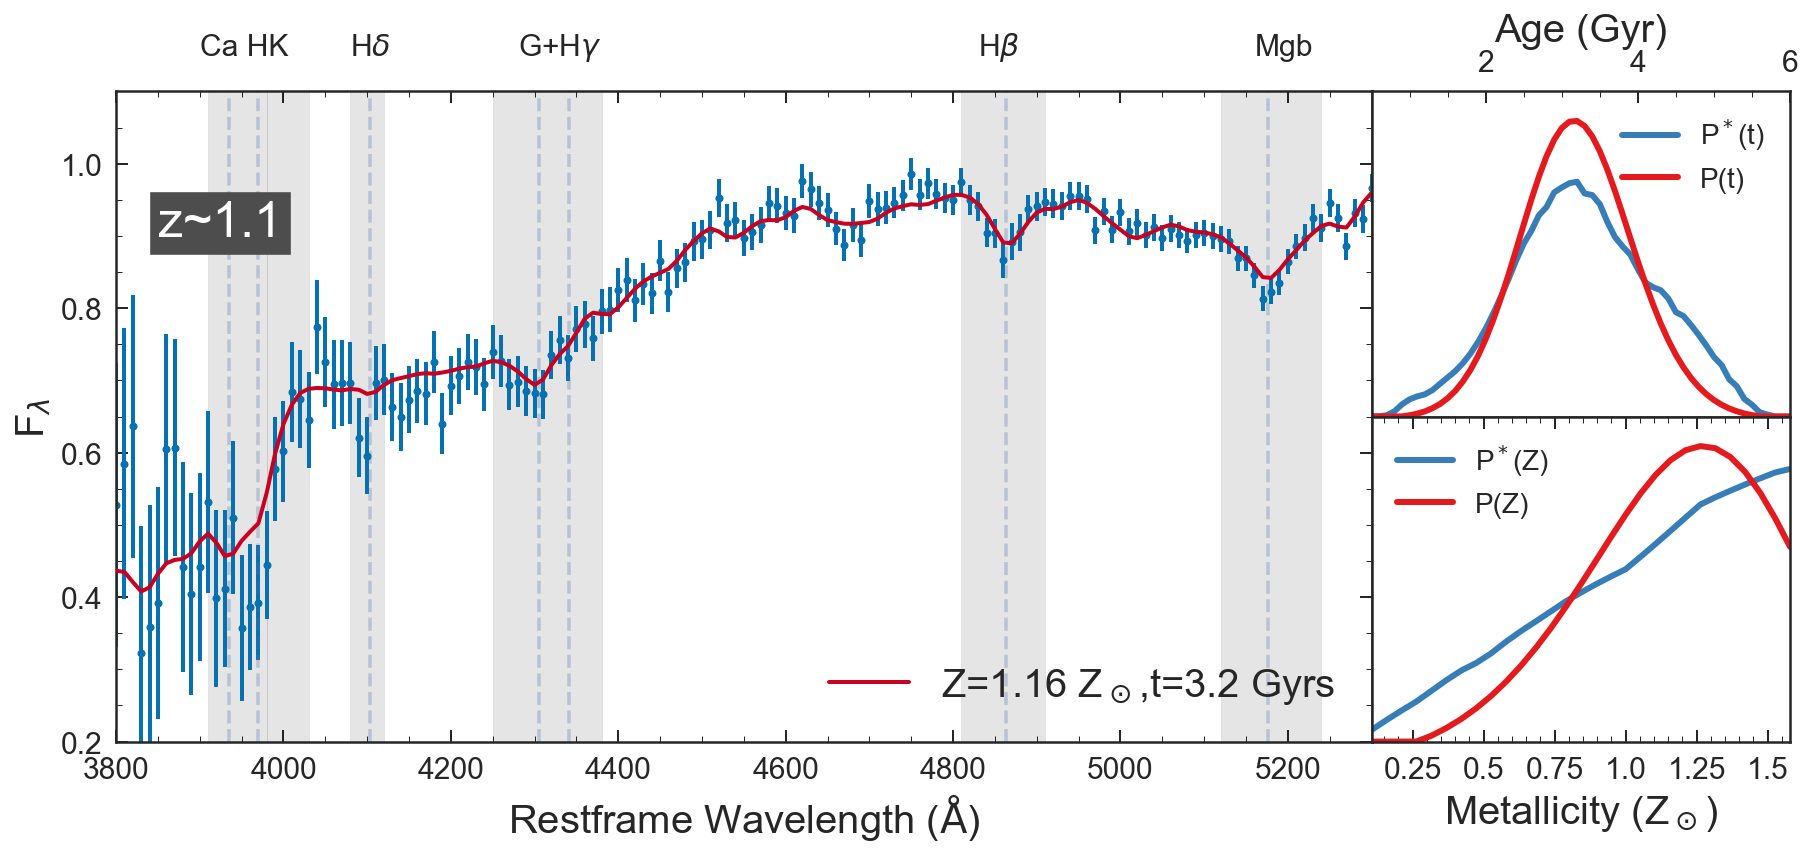

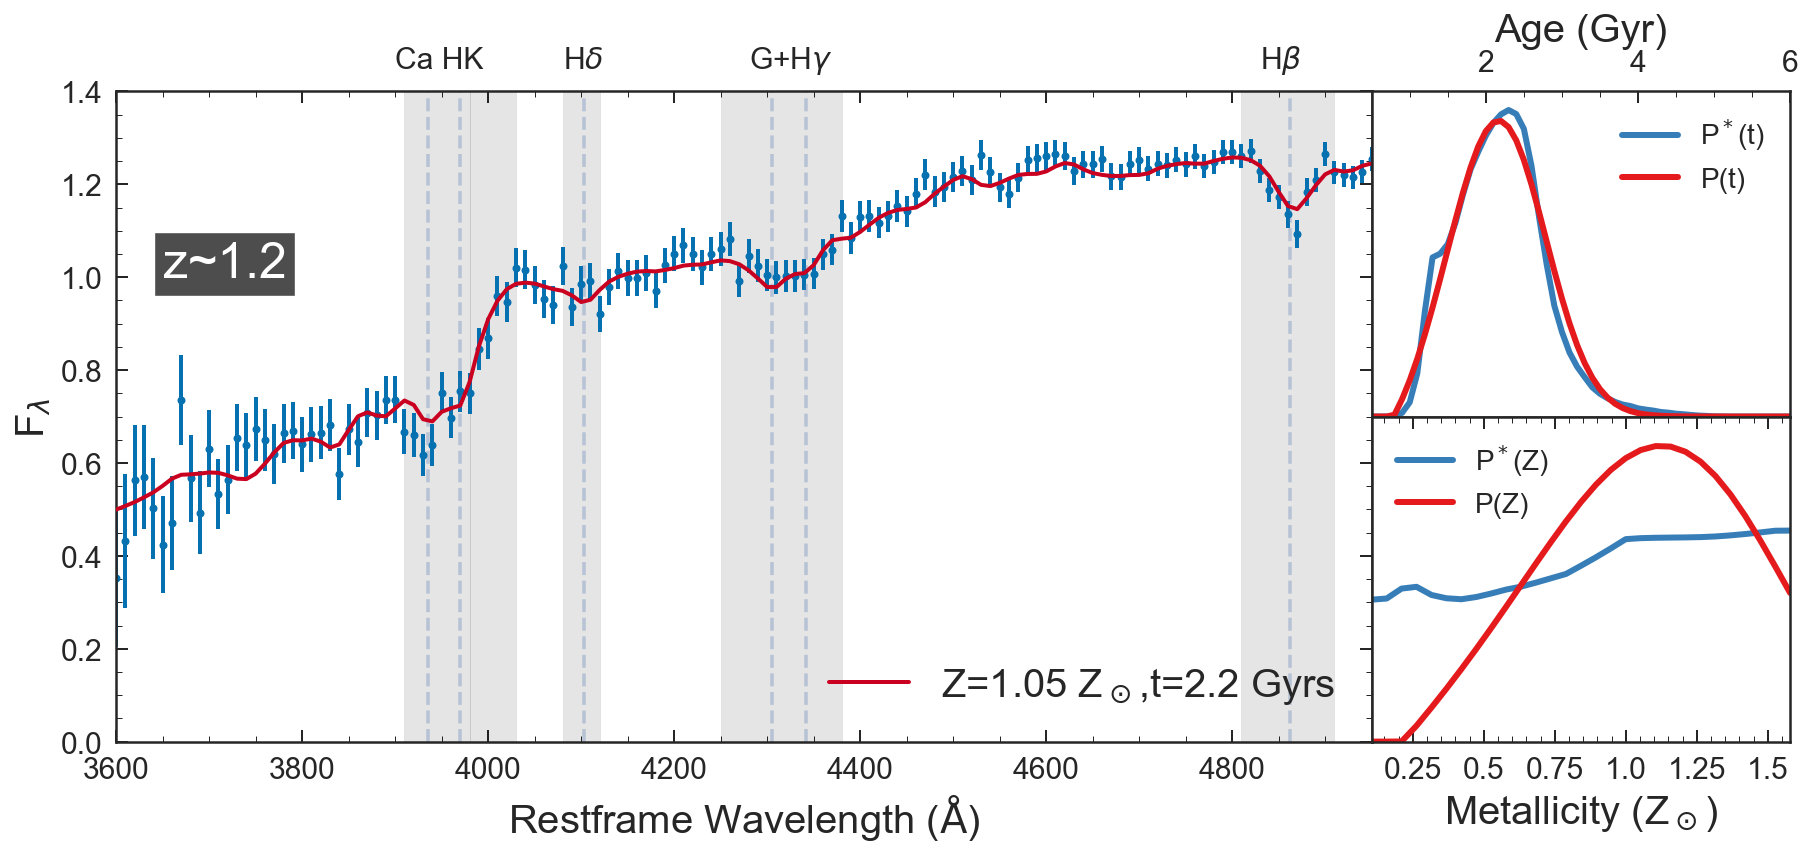

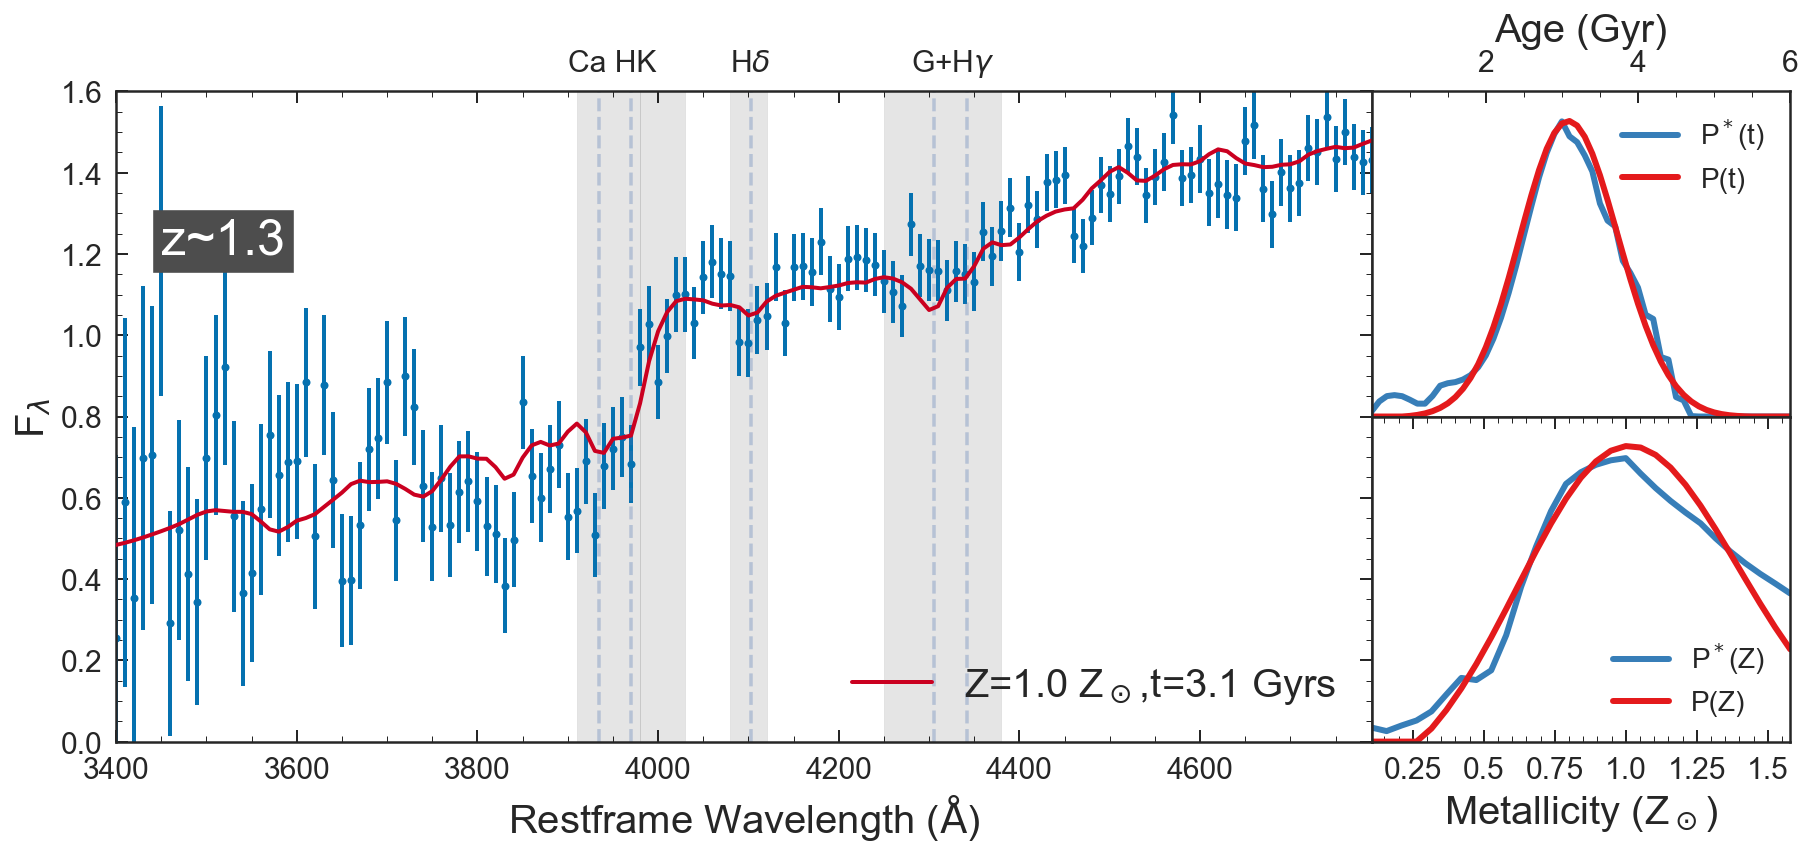

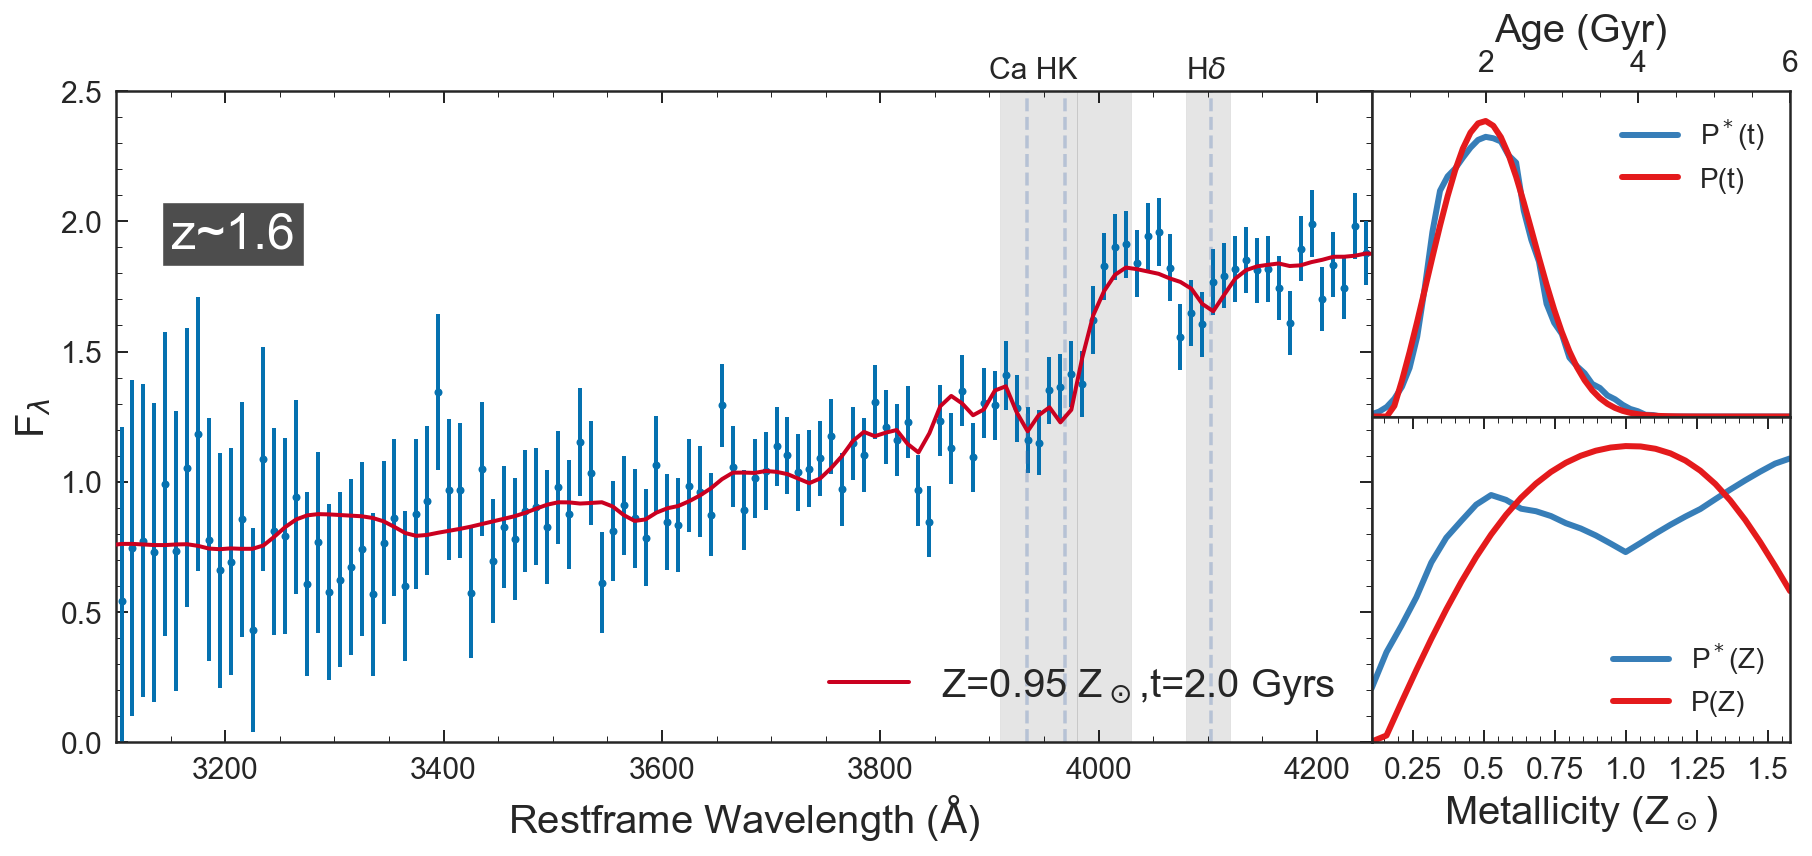

In [6]:
Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,Zmedl,tmedl,PTl,age,PZl,metal,wPTl,wPZl,
           window=[3800,5300,.2,1.1],group='z~1.1',group_win=[3850,0.9],save_plot=True,
           plot_name='../plots/stack_lz_bf_8-13.png')

Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,Zmedm,tmedm,PTm,age,PZm,metal,wPTm,wPZm,
           window=[3600,4950,0,1.4],group='z~1.2',group_win=[3650,1.0],save_plot=True,
           plot_name='../plots/stack_mz_bf_8-13.png')

Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,Zmedh,tmedh,PTh,age,PZh,metal,wPTh,wPZh,
           window=[3400,4790,0,1.6],group='z~1.3',group_win=[3450,1.2],save_plot=True,
           plot_name='../plots/stack_hz_bf_8-13.png')

Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,Zmeduh,tmeduh,PTuh,age,PZuh,metal,wPTuh,wPZuh,
           window=[3100,4250,0.,2.5],group='z~1.6',group_win=[3150,1.9],save_plot=True,
            plot_name='../plots/stack_uhz_bf_8-13.png')

In [ ]:
\zone &$1.16_{-0.33}^{+0.26}$ & $3.2 \pm 0.7$ & 10.1--11.1  & 12\\
\ztwo &$1.05_{-0.36}^{+0.32}$&$2.2 \pm 0.6$   & 10.6--11.2 & 9\\
\zthree &$1.00_{-0.31}^{+0.31}$&$3.1 \pm 0.6$ & 10.5--11.0 & 5 \\
\zsix &$0.95_{-0.40}^{+0.37}$&$2.0 \pm 0.6$  & 10.7--11.1 & 5\\

In [27]:
med,l,h = Median_w_Error(PTuh,age)
print(np.round(np.array([med,l,h]),1))

[2.  0.6 0.6]


In [19]:
print(galDB.Zx[4]/0.019,(galDB.Zx_l[4]+galDB.Zx_h[4])/0.019)
print(galDB.tx[4],(galDB.tx_l[4]+galDB.tx_h[4]))

0.7372640016875857 0.9923003902541924
2.3186372745490984 1.4328657314629258


In [70]:
spec = Gen_spec(galDB.gids[2], galDB.z_grism[2],minwv=7800,maxwv=11100)
spec.Sim_spec(0.02,2.2,8.48)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

(0, 0.001202228225731431)

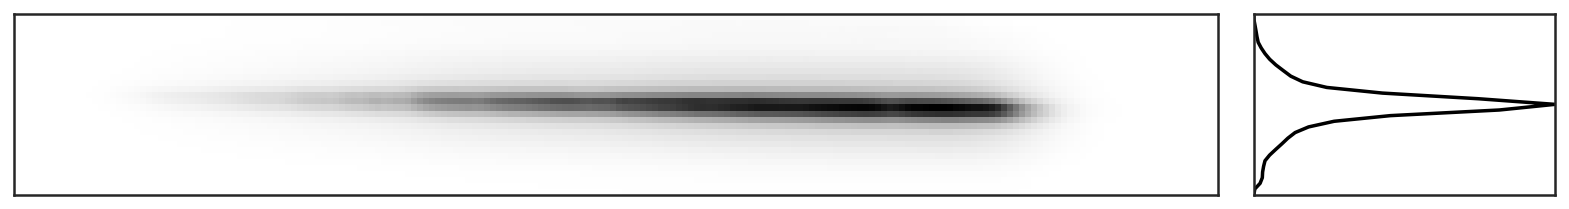

In [150]:
plt.figure(figsize=[14,1.66])
gs = gridspec.GridSpec(1,10,wspace=0.1)
plt.subplot(gs[0,0:8])
plt.imshow(spec.beam.model[65:95,75:275],cmap='binary')
plt.xticks([])
plt.yticks([])
plt.subplot(gs[0,8:])
plt.plot(sum(adjimg.T),np.arange(len(sum(adjimg.T))),'k')
plt.xticks([])
plt.yticks([])
plt.ylim(0,len(sum(adjimg.T))-1)
plt.xlim(0,max(sum(adjimg.T)))

In [117]:
adjimg = interpolation.rotate(spec.beam.model[65:95,75:275],angle=.8)

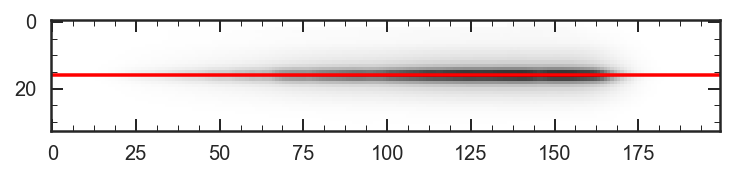

In [118]:
plt.imshow(adjimg,cmap='binary')
plt.axhline(16,color='r')

In [25]:
'../mcerr/MC_1.1_m0.019_a'

-0.9777236052888477

In [3]:
upd_fast_s = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/south.fout',format='ascii').to_pandas()
upd_fast_n = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/north.fout',format='ascii').to_pandas()

In [4]:
rf_lmass=[]

for i in galDB.index:
    if galDB.gids[i][0] == 's':
        rf_lmass.append(upd_fast_s['col17'][upd_fast_s.col1 == int(galDB.gids[i][1:])].values[0])
    if galDB.gids[i][0] == 'n':
        rf_lmass.append(upd_fast_n['col17'][upd_fast_n.col1 == int(galDB.gids[i][1:])].values[0])


# Redshift MCerr

In [49]:
"""DATA"""
sn = np.array([2,5,10,15,20])#,30,40,50,100,500])
sn39 = np.array([2,5,10,15,20])
sn21 = np.array([2,5,10,15])
sn40 = np.array([2,5,10])
sn44 = np.array([2,5])

mp = [0.019]
ap = [2.5]

m39, ml39, mh39, a39, al39, ah39 = np.zeros([6,5])
m21, ml21, mh21, a21, al21, ah21 = np.zeros([6,5])
m40, ml40, mh40, a40, al40, ah40 = np.zeros([6,5])
m44, ml44, mh44, a44, al44, ah44 = np.zeros([6,5])

for i in range(len(sn)):
    PZtest = np.load('../mcerr/PZ_MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pttest = np.load('../mcerr/Pt_MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    if sn[i] == 2:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=True)
    else:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=False)
    tstk,twstk = Iterative_stacking(Pttest,age,1)
    m39[i], ml39[i], mh39[i] = Median_w_Error_cont(mstk,metal)
    a39[i], al39[i], ah39[i] = Median_w_Error_cont(tstk,age)
    m39[i] -= 0.019
    a39[i] -= 2.5
    
for i in range(len(sn)):
    PZtest = np.load('../mcerr/PZ_MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pttest = np.load('../mcerr/Pt_MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    if sn[i] == 2 or sn[i] == 5:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=True)
    else:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=False)    
    tstk,twstk = Iterative_stacking(Pttest,age,1)
    m21[i], ml21[i], mh21[i] = Median_w_Error_cont(mstk,metal)
    a21[i], al21[i], ah21[i] = Median_w_Error_cont(tstk,age)
    m21[i] -= 0.019
    a21[i] -= 2.5
    
for i in range(len(sn)):
    PZtest = np.load('../mcerr/PZ_MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pttest = np.load('../mcerr/Pt_MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    if sn[i] == 2:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=True)
    else:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=False)
    tstk,twstk = Iterative_stacking(Pttest,age,1)
    m40[i], ml40[i], mh40[i] = Median_w_Error_cont(mstk,metal)
    a40[i], al40[i], ah40[i] = Median_w_Error_cont(tstk,age)
    m40[i] -= 0.019
    a40[i] -= 2.5
    
for i in range(len(sn)):
    PZtest = np.load('../mcerr/PZ_MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pttest = np.load('../mcerr/Pt_MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    if sn[i] == 2:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=True)
    else:
        mstk,mwstk = Iterative_stacking(PZtest,metal,3,extend=False)    
    tstk,twstk = Iterative_stacking(Pttest,age,1)
    m44[i], ml44[i], mh44[i] = Median_w_Error_cont(mstk,metal)
    a44[i], al44[i], ah44[i] = Median_w_Error_cont(tstk,age)
    m44[i] -= 0.019
    a44[i] -= 2.5

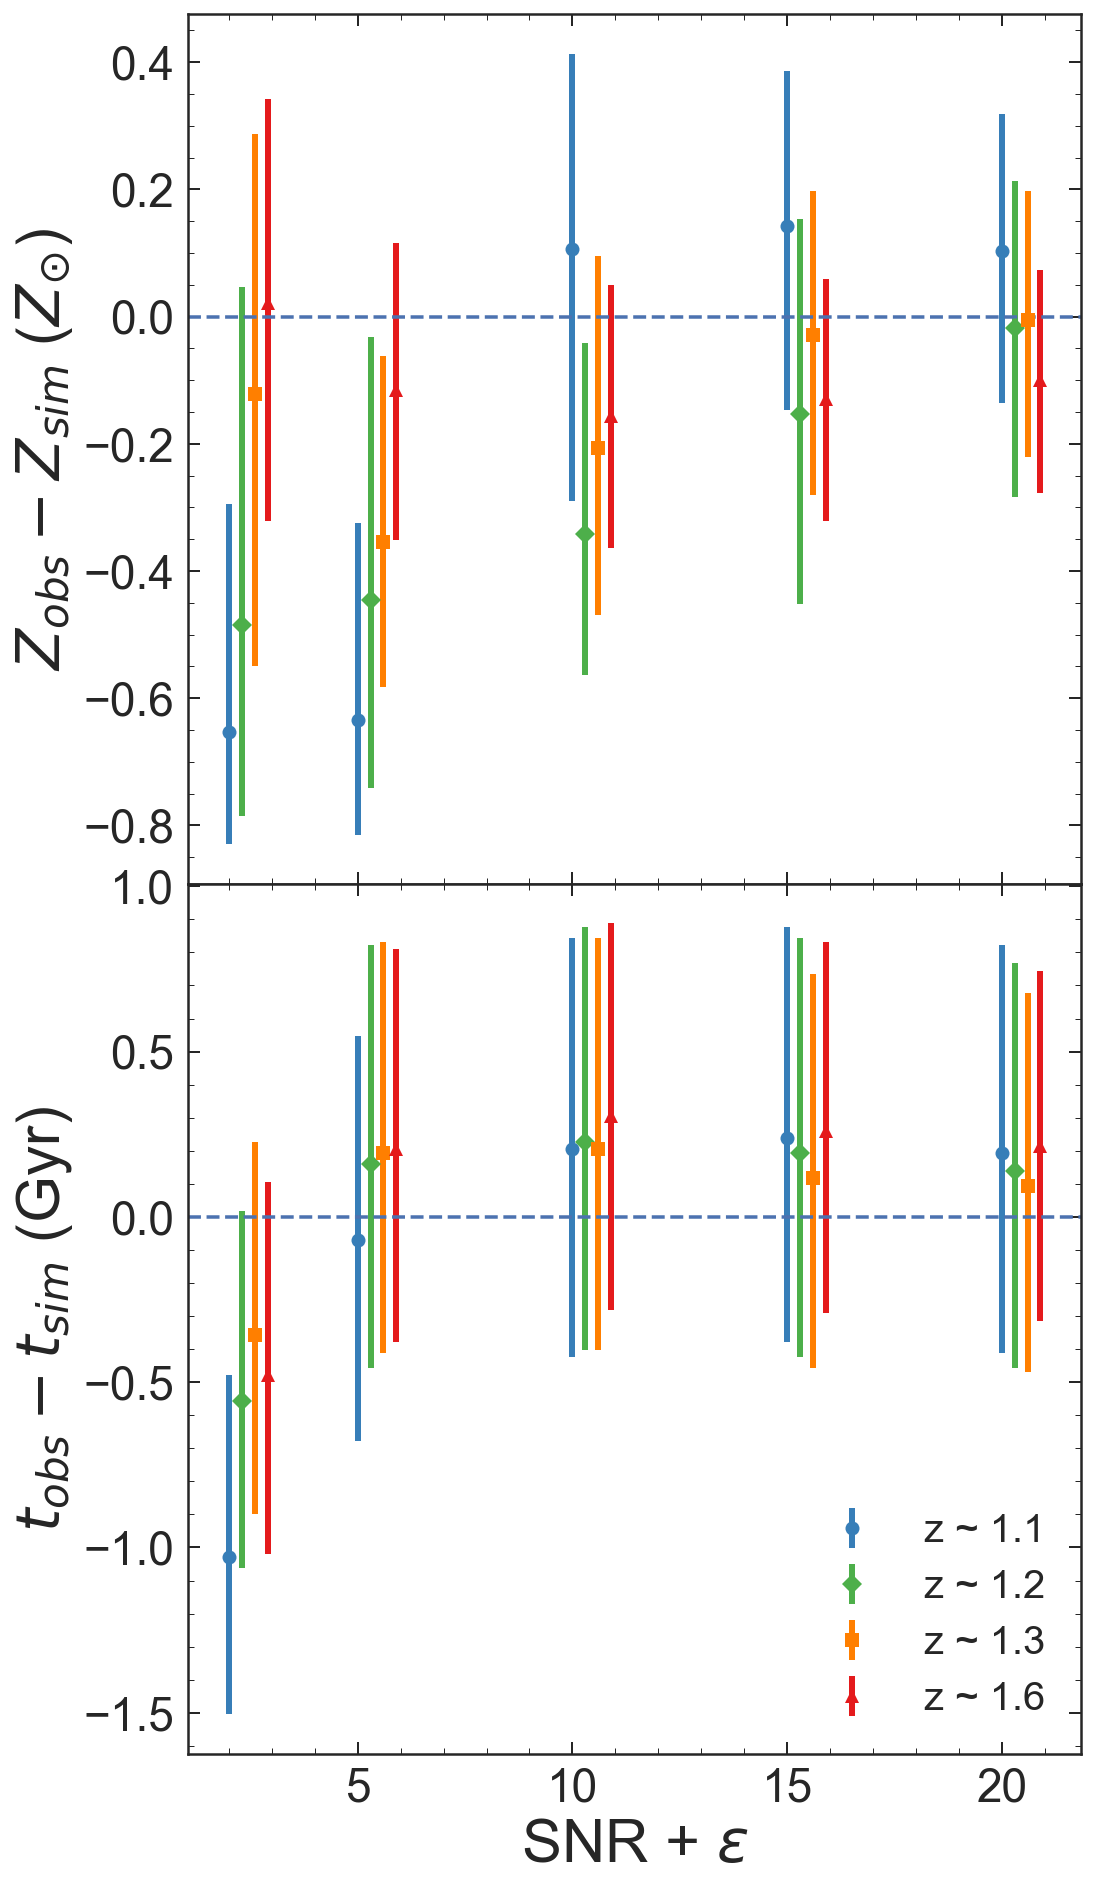

In [51]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1,hspace=0)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
plt.errorbar(sn,m39/.019,yerr=[ml39/.019,mh39/.019],linestyle='None', elinewidth=3, marker='o', color='#377eb8',label='z ~ 1.1',ms=7)
plt.errorbar(sn+.3,m21/.019,yerr=[ml21/.019,mh21/.019],linestyle='None', elinewidth=3, marker='D', color='#4daf4a',label='z ~ 1.2',ms=7)
plt.errorbar(sn+.6,m40/.019,yerr=[ml40/.019,mh40/.019],linestyle='None', elinewidth=3, marker='s', color='#ff7f00',label='z ~ 1.3',ms=7)
plt.errorbar(sn+.9,m44/.019,yerr=[ml44/.019,mh44/.019],linestyle='None', elinewidth=3, marker='^', color='#e41a1c',label='z ~ 1.6',ms=7)
plt.axhline(0,linestyle='--')
plt.ylabel('$Z_{obs} - Z_{sim}$ ($Z_{\odot}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.xscale('log')

plt.subplot(gs[1])
plt.errorbar(sn,a39,yerr=[al39,ah39],linestyle='None', elinewidth=3, marker='o',color='#377eb8',label='z ~ 1.1',ms=7)
plt.errorbar(sn+.3,a21,yerr=[al21,ah21],linestyle='None', elinewidth=3, marker='D', color='#4daf4a',label='z ~ 1.2',ms=7)
plt.errorbar(sn+.6,a40,yerr=[al40,ah40],linestyle='None', elinewidth=3, marker='s', color='#ff7f00',label='z ~ 1.3',ms=7)
plt.errorbar(sn+.9,a44,yerr=[al44,ah44],linestyle='None', elinewidth=3, marker='^', color='#e41a1c',label='z ~ 1.6',ms=7)
plt.xlabel('SNR + $\epsilon$',fontsize = 30)
plt.ylabel('$t_{obs} - t_{sim}$ (Gyr)',fontsize = 30)
plt.axhline(0,linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(loc=4,fontsize=20)
# plt.xscale('log')
plt.savefig('../plots/mctest.pdf',bbox_inches = 'tight')


In [64]:
"""DATA"""
sn = np.array([2,5,10,15,20])#,30,40,50,100,500])
sn39 = np.array([2,5,10,15,20])
sn21 = np.array([2,5,10,15])
sn40 = np.array([2,5,10])
sn44 = np.array([2,5])

mp = [0.019]
ap = [2.5]

m39, ml39, mh39, a39, al39, ah39 = np.zeros([6,5])
m21, ml21, mh21, a21, al21, ah21 = np.zeros([6,5])
m40, ml40, mh40, a40, al40, ah40 = np.zeros([6,5])
m44, ml44, mh44, a44, al44, ah44 = np.zeros([6,5])

def Z_group_stats(dist):
    sorted_dist = np.sort(dist)
    med = sorted_dist[499]
    lerr = sorted_dist[499] - sorted_dist[159]
    herr = sorted_dist[839] - sorted_dist[499] 
    return med, lerr, herr

for i in range(len(sn)):
    mdf1,adf1 = np.load('../mcerr/MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    dm = mdf1 - mp[0]
    da = adf1 - ap[0]
    
    m39[i], ml39[i], mh39[i] = Z_group_stats(dm)
    a39[i], al39[i], ah39[i] = Z_group_stats(da)
    
    mdf1,adf1 = np.load('../mcerr/MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    dm = mdf1 - mp[0]
    da = adf1 - ap[0]
    m21[i], ml21[i], mh21[i] = Z_group_stats(dm)
    a21[i], al21[i], ah21[i] = Z_group_stats(da)
    
    mdf1,adf1 = np.load('../mcerr/MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    dm = mdf1 - mp[0]
    da = adf1 - ap[0]
    m40[i], ml40[i], mh40[i] = Z_group_stats(dm)
    a40[i], al40[i], ah40[i] = Z_group_stats(da)
 
    mdf1,adf1 = np.load('../mcerr/MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    dm = mdf1 - mp[0]
    da = adf1 - ap[0]
    m44[i], ml44[i], mh44[i] = Z_group_stats(dm)
    a44[i], al44[i], ah44[i] = Z_group_stats(da) 

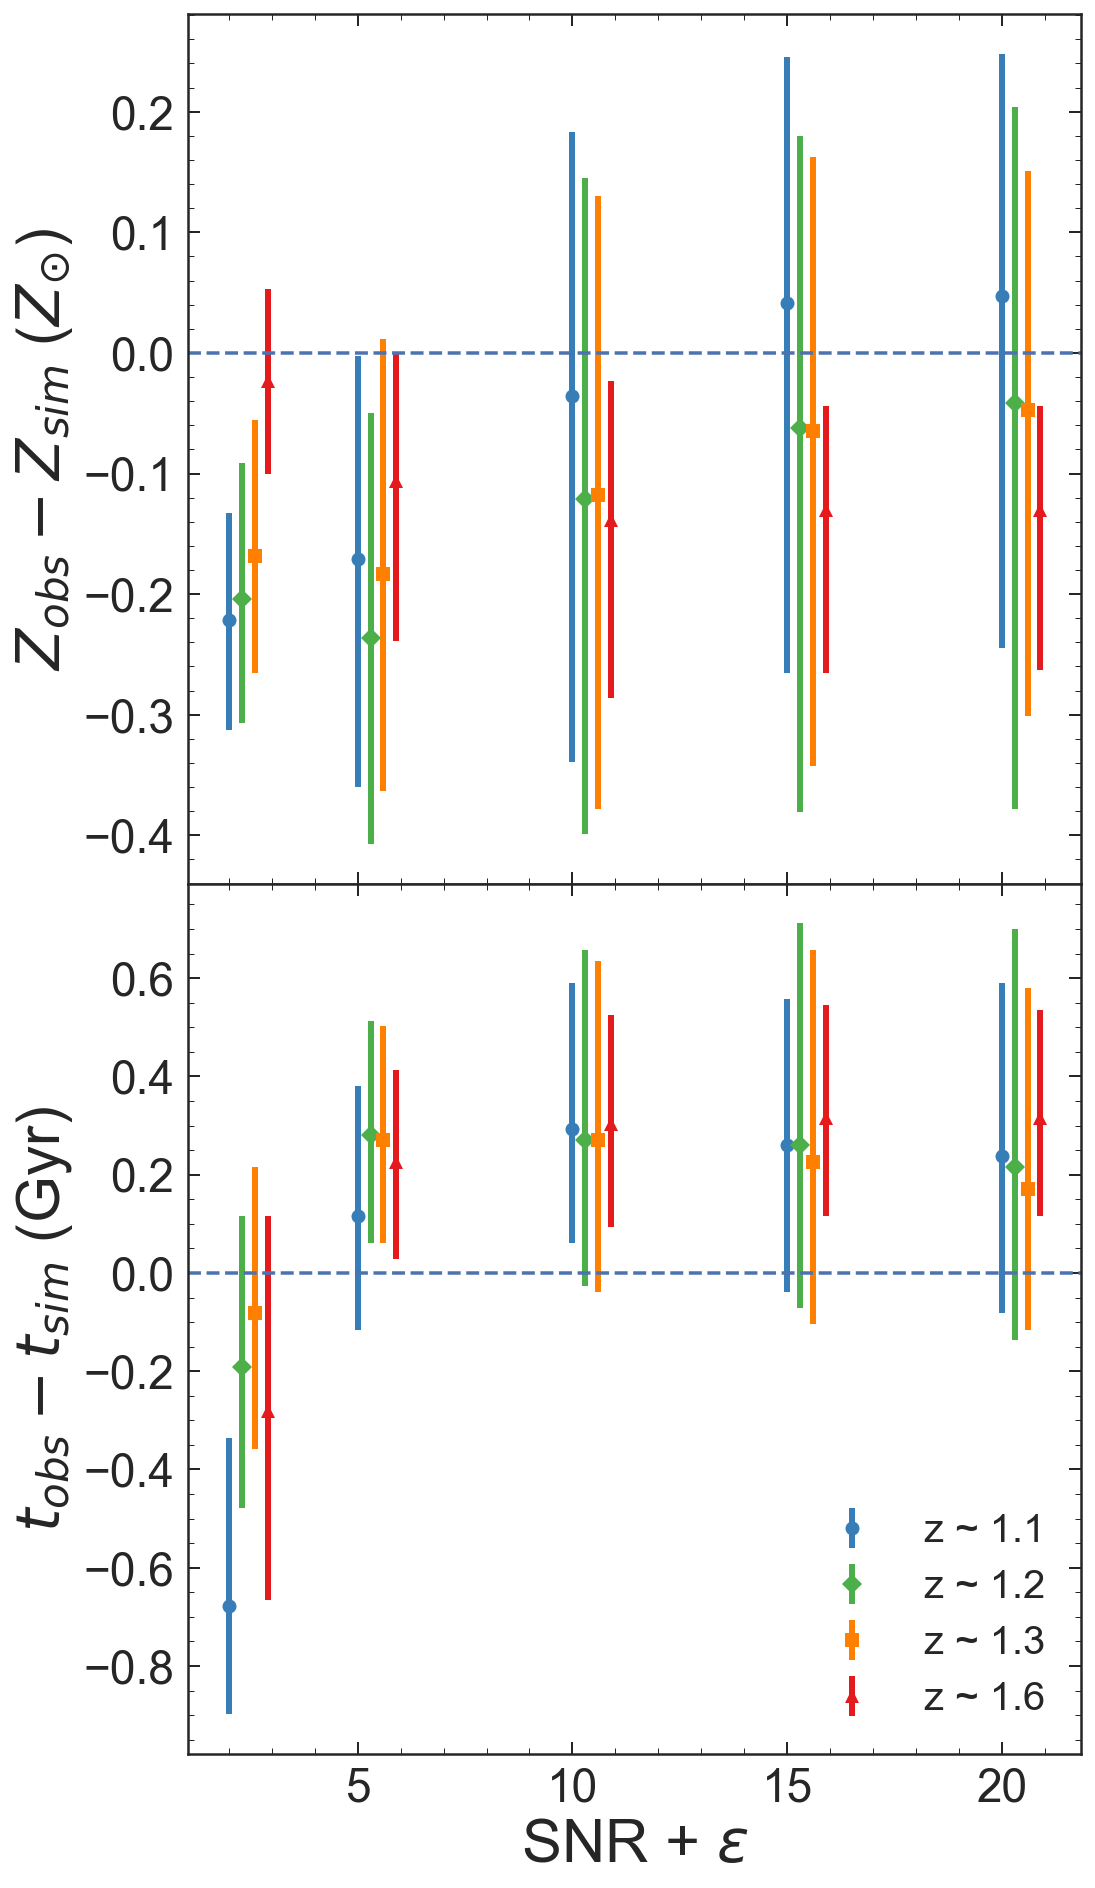

In [65]:
"""PLOT"""
gs = gridspec.GridSpec(2,1,hspace=0)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
plt.errorbar(sn,m39/.019,yerr=[ml39/.019,mh39/.019],linestyle='None', elinewidth=3, marker='o', color='#377eb8',label='z ~ 1.1',ms=7)
plt.errorbar(sn+.3,m21/.019,yerr=[ml21/.019,mh21/.019],linestyle='None', elinewidth=3, marker='D', color='#4daf4a',label='z ~ 1.2',ms=7)
plt.errorbar(sn+.6,m40/.019,yerr=[ml40/.019,mh40/.019],linestyle='None', elinewidth=3, marker='s', color='#ff7f00',label='z ~ 1.3',ms=7)
plt.errorbar(sn+.9,m44/.019,yerr=[ml44/.019,mh44/.019],linestyle='None', elinewidth=3, marker='^', color='#e41a1c',label='z ~ 1.6',ms=7)
plt.axhline(0,linestyle='--')
plt.ylabel('$Z_{obs} - Z_{sim}$ ($Z_{\odot}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.xscale('log')

plt.subplot(gs[1])
plt.errorbar(sn,a39,yerr=[al39,ah39],linestyle='None', elinewidth=3, marker='o',color='#377eb8',label='z ~ 1.1',ms=7)
plt.errorbar(sn+.3,a21,yerr=[al21,ah21],linestyle='None', elinewidth=3, marker='D', color='#4daf4a',label='z ~ 1.2',ms=7)
plt.errorbar(sn+.6,a40,yerr=[al40,ah40],linestyle='None', elinewidth=3, marker='s', color='#ff7f00',label='z ~ 1.3',ms=7)
plt.errorbar(sn+.9,a44,yerr=[al44,ah44],linestyle='None', elinewidth=3, marker='^', color='#e41a1c',label='z ~ 1.6',ms=7)
plt.xlabel('SNR + $\epsilon$',fontsize = 30)
plt.ylabel('$t_{obs} - t_{sim}$ (Gyr)',fontsize = 30)
plt.axhline(0,linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(loc=4,fontsize=20)
# plt.xscale('log')
# plt.savefig('../plots/mctest.pdf',bbox_inches = 'tight')


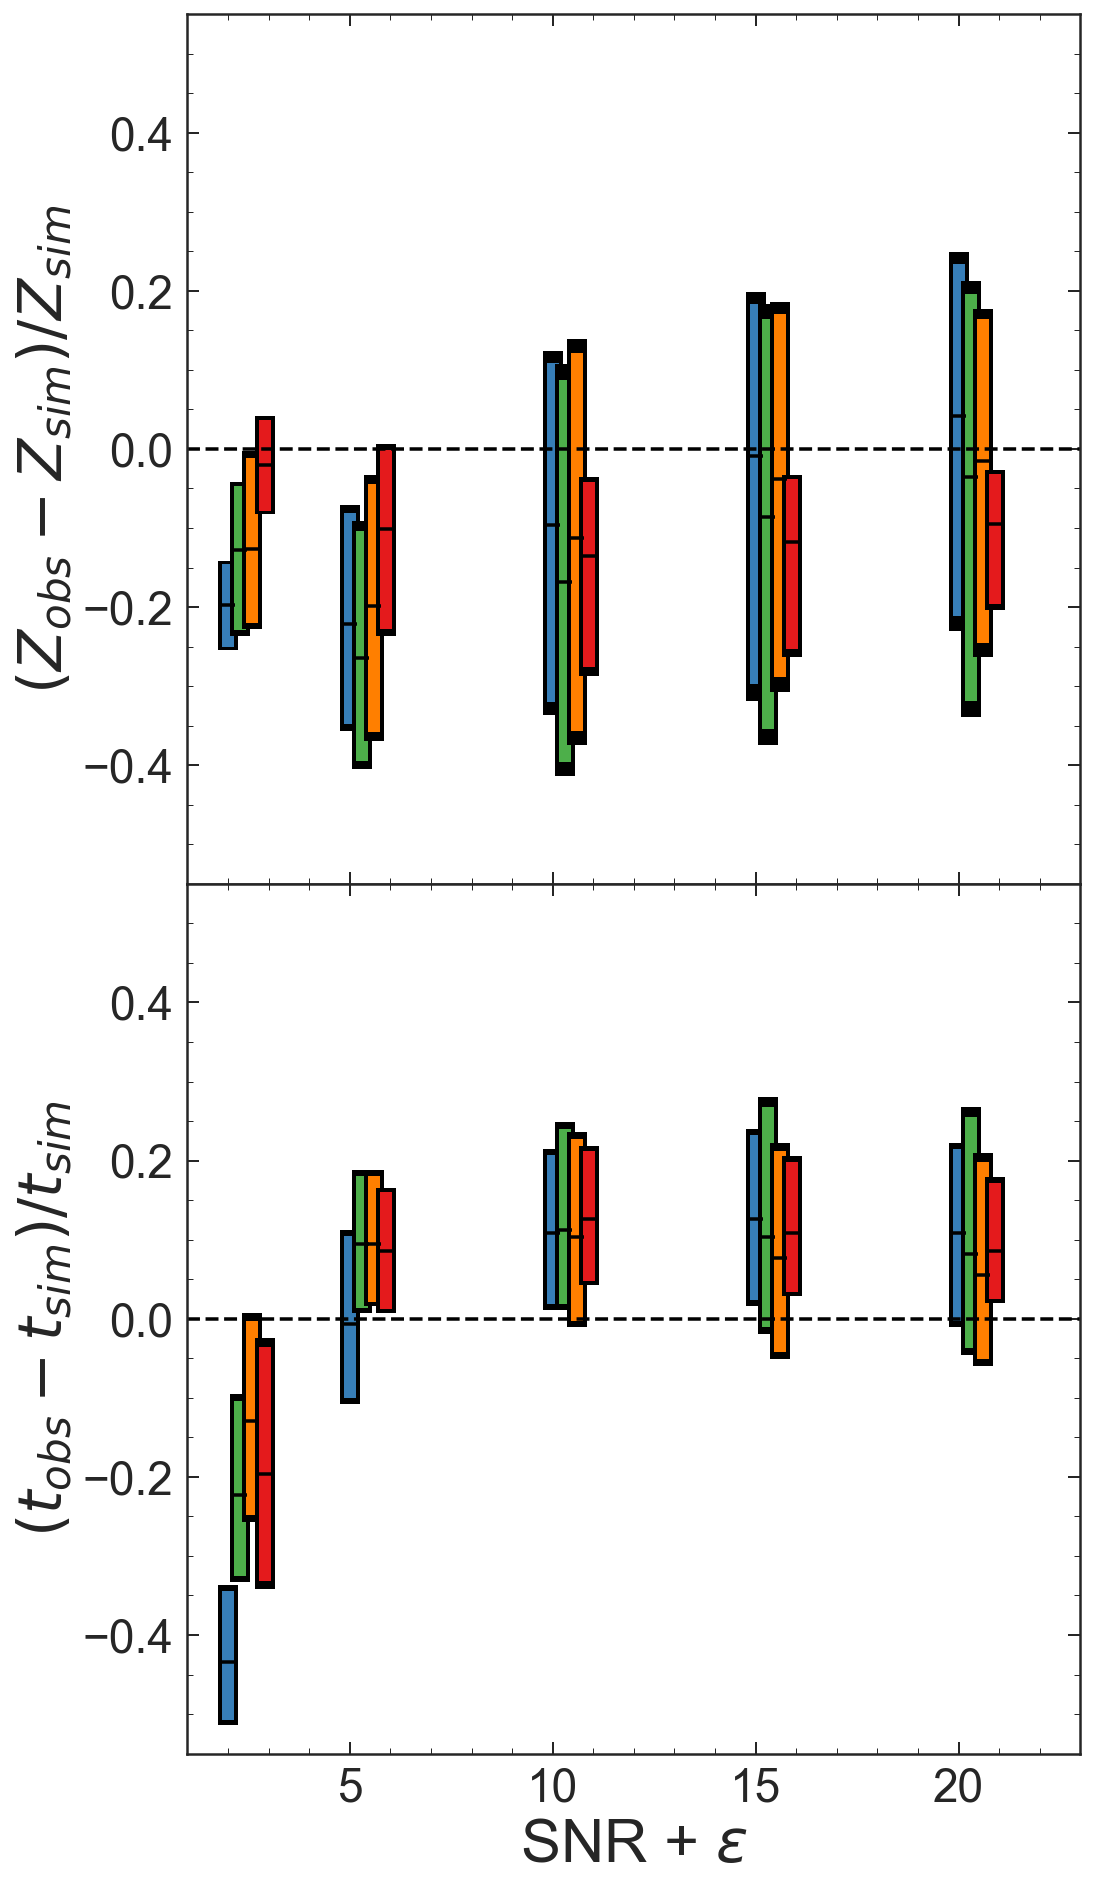

In [34]:
"""PLOT"""

def Plot_box(ax,x,dist,col):
    ax.errorbar(x,np.median(dist),
                 yerr=[[np.median(dist) -np.percentile(dist,16)],[np.percentile(dist,84)-np.median(dist)]],linestyle='None', 
                 elinewidth=10, marker='None', color='k',)
    ax.errorbar(x,np.median(dist),
                 yerr=[[(np.median(dist) -np.percentile(dist,16))*.93],[(np.percentile(dist,84)-np.median(dist))*.93]], 
             linestyle='None', elinewidth=6, marker='None', color=col)
    ax.scatter(x,np.median(dist),color='k',marker='_',zorder=5)
    
"""DATA"""
sn = np.array([2,5,10,15,20])#,30,40,50,100,500])


mp = [0.019]
ap = [2.5]

mdict1 = {}
mdict2 = {}
mdict3 = {}
mdict6 = {}

gs = gridspec.GridSpec(2,1,hspace=0)
plt.figure(figsize=[8,16])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
for i in range(len(sn)):
    mdf1,adf1 = np.load('../mcerr/MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    mdist = (mdf1-0.019)/0.019
    adist = (adf1 - 2.5)/2.5
    Plot_box(ax1,sn[i],mdist,'#377eb8')
    Plot_box(ax2,sn[i],adist,'#377eb8')
    
    mdf1,adf1 = np.load('../mcerr/MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    mdist = (mdf1-0.019)/0.019
    adist = (adf1 - 2.5)/2.5
    Plot_box(ax1,sn[i]+.3,mdist,'#4daf4a')
    Plot_box(ax2,sn[i]+.3,adist,'#4daf4a')

    mdf1,adf1 = np.load('../mcerr/MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    mdist = (mdf1-0.019)/0.019
    adist = (adf1 - 2.5)/2.5
    Plot_box(ax1,sn[i]+.6,mdist,'#ff7f00')
    Plot_box(ax2,sn[i]+.6,adist,'#ff7f00')

    mdf1,adf1 = np.load('../mcerr/MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    mdist = (mdf1-0.019)/0.019
    adist = (adf1 - 2.5)/2.5
    Plot_box(ax1,sn[i]+.9,mdist,'#e41a1c')
    Plot_box(ax2,sn[i]+.9,adist,'#e41a1c')

ax1.axhline(0,color='k',linestyle='--')
ax1.set_ylabel('$(Z_{obs} - Z_{sim}) / Z_{sim}$',fontsize = 30)
ax1.set_yticks([-.4,-.2,0,.2,.4])
ax1.tick_params(axis='both', which='major', labelsize=23)
ax1.axis([1,23,-.55,.55])

ax2.axhline(0,color='k',linestyle='--')
ax2.set_xlabel('SNR + $\epsilon$',fontsize = 30)
ax2.set_ylabel('$(t_{obs} - t_{sim}) / t_{sim}$',fontsize = 30)
ax2.axis([1,23,-.55,.55])
ax2.tick_params(axis='both', which='major', labelsize=23)
plt.savefig('../plots/mctest.pdf',bbox_inches = 'tight')


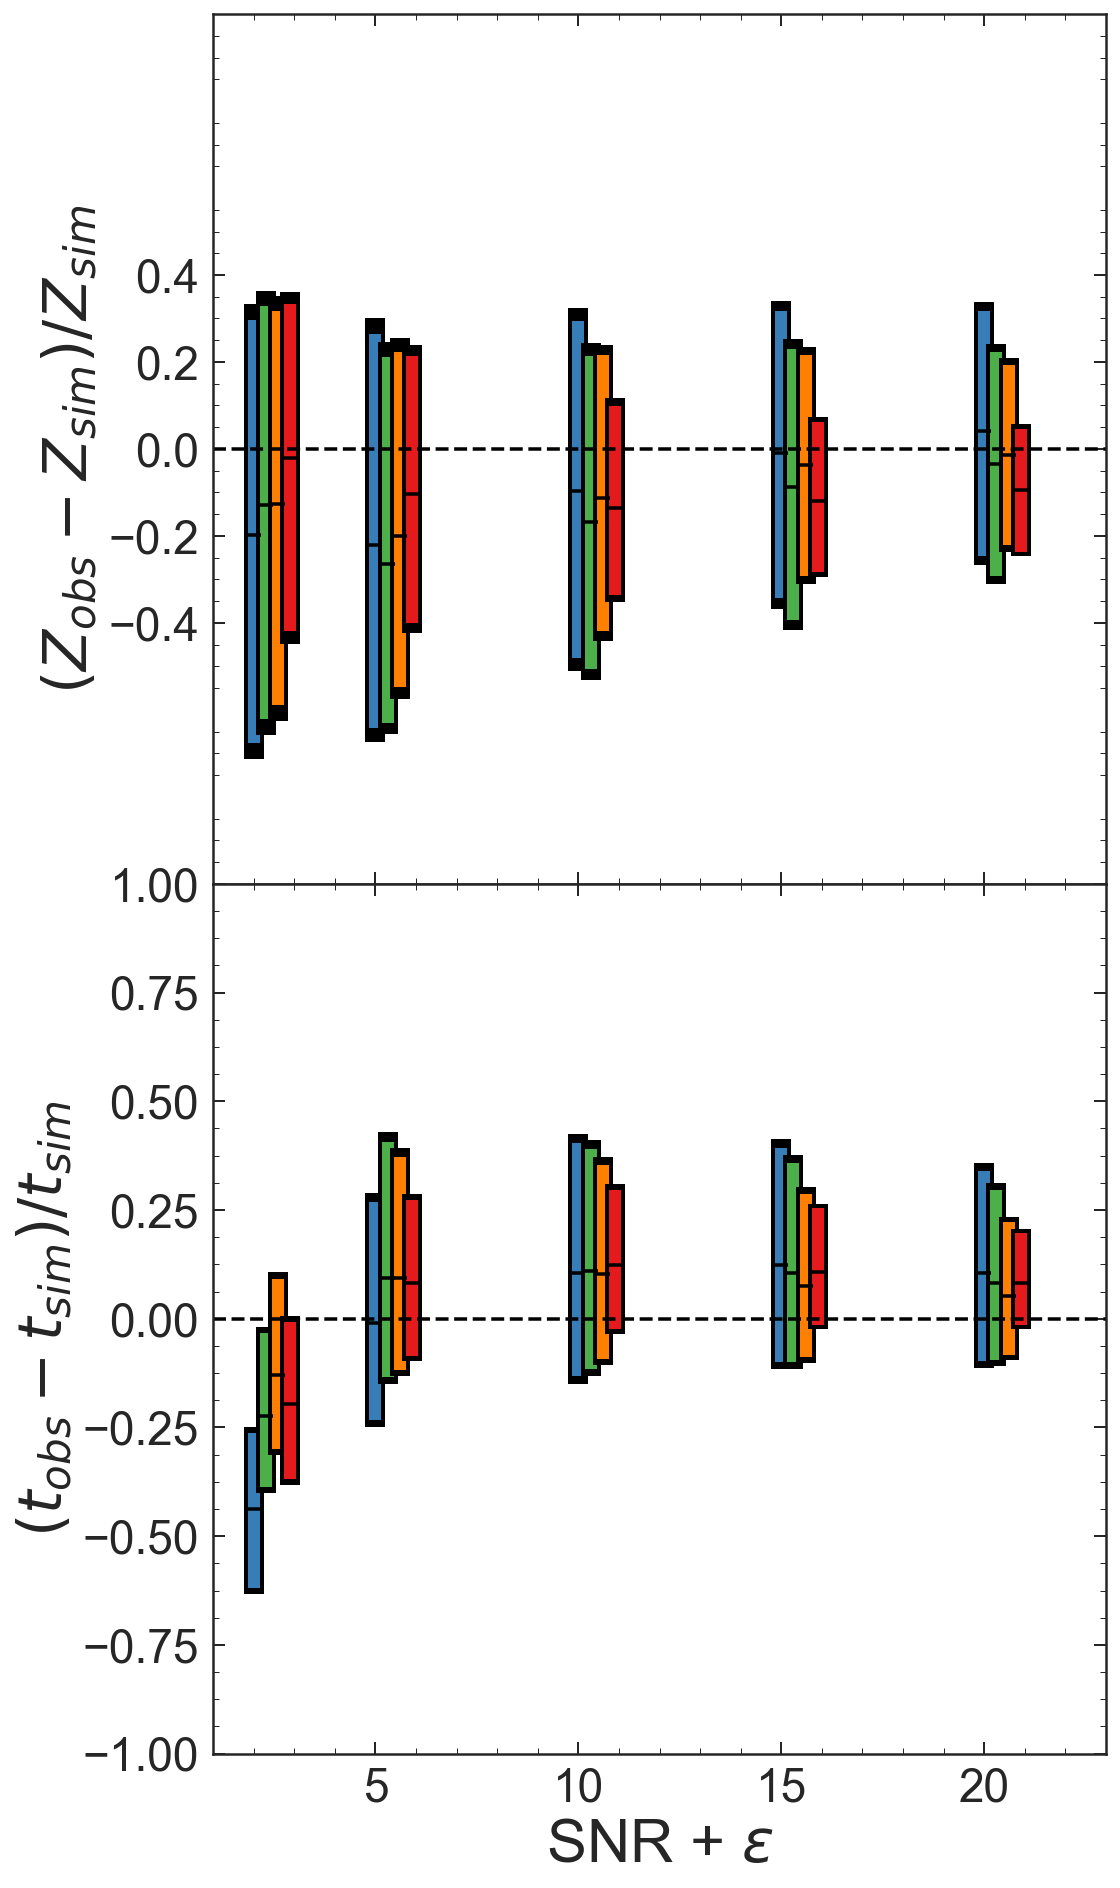

In [258]:
"""PLOT"""

def Plot_box(ax,x,med,low,high,col):
    ax.errorbar(x,np.median(med),yerr=[[np.median(low)],[np.median(high)]],linestyle='None', 
                 elinewidth=10, marker='None', color='k',)
    ax.errorbar(x,np.median(med),yerr=[[np.median(low)*.93],[np.median(high)*.93]], 
             linestyle='None', elinewidth=6, marker='None', color=col)
    ax.scatter(x,np.median(med),color='k',marker='_',zorder=5)
    
"""DATA"""
sn = np.array([2,5,10,15,20])#,30,40,50,100,500])

mp = [0.019]
ap = [2.5]

gs = gridspec.GridSpec(2,1,hspace=0)
plt.figure(figsize=[8,16])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
for i in range(len(sn)):
    mdf1,adf1 = np.load('../mcerr/MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    PZ = np.load('../mcerr/PZ_MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pt = np.load('../mcerr/Pt_MC_1.1_m0.019_a2.5_sn{0}.npy'.format(sn[i]))

    m,ml,mh = np.zeros([3,1000])
    a,al,ah = np.zeros([3,1000])

    for ii in range(len(Pt)):
        m[ii],ml[ii],mh[ii] = Median_w_Error_cont(PZ[ii],metal)
        a[ii],al[ii],ah[ii] = Median_w_Error_cont(Pt[ii],age)
    
    Plot_box(ax1,sn[i],(m-0.019)/0.019,ml/0.019,mh/0.019,'#377eb8')
    Plot_box(ax2,sn[i],(a-2.5)/2.5,al/2.5,ah/2.5,'#377eb8')
    
    ####
    mdf1,adf1 = np.load('../mcerr/MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    PZ = np.load('../mcerr/PZ_MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pt = np.load('../mcerr/Pt_MC_1.2_m0.019_a2.5_sn{0}.npy'.format(sn[i]))

    m,ml,mh = np.zeros([3,1000])
    a,al,ah = np.zeros([3,1000])

    for ii in range(len(Pt)):
        m[ii],ml[ii],mh[ii] = Median_w_Error_cont(PZ[ii],metal)
        a[ii],al[ii],ah[ii] = Median_w_Error_cont(Pt[ii],age)
    
    Plot_box(ax1,sn[i]+.3,(m-0.019)/0.019,ml/0.019,mh/0.019,'#4daf4a')
    Plot_box(ax2,sn[i]+.3,(a-2.5)/2.5,al/2.5,ah/2.5,'#4daf4a')

    ####
    mdf1,adf1 = np.load('../mcerr/MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    PZ = np.load('../mcerr/PZ_MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pt = np.load('../mcerr/Pt_MC_1.3_m0.019_a2.5_sn{0}.npy'.format(sn[i]))

    m,ml,mh = np.zeros([3,1000])
    a,al,ah = np.zeros([3,1000])

    for ii in range(len(Pt)):
        m[ii],ml[ii],mh[ii] = Median_w_Error_cont(PZ[ii],metal)
        a[ii],al[ii],ah[ii] = Median_w_Error_cont(Pt[ii],age)
    
    Plot_box(ax1,sn[i]+.6,(m-0.019)/0.019,ml/0.019,mh/0.019,'#ff7f00')
    Plot_box(ax2,sn[i]+.6,(a-2.5)/2.5,al/2.5,ah/2.5,'#ff7f00')

    ####
    mdf1,adf1 = np.load('../mcerr/MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    PZ = np.load('../mcerr/PZ_MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))
    Pt = np.load('../mcerr/Pt_MC_1.6_m0.019_a2.5_sn{0}.npy'.format(sn[i]))

    m,ml,mh = np.zeros([3,1000])
    a,al,ah = np.zeros([3,1000])

    for ii in range(len(Pt)):
        m[ii],ml[ii],mh[ii] = Median_w_Error_cont(PZ[ii],metal)
        a[ii],al[ii],ah[ii] = Median_w_Error_cont(Pt[ii],age)
    
    Plot_box(ax1,sn[i]+.9,(m-0.019)/0.019,ml/0.019,mh/0.019,'#e41a1c')
    Plot_box(ax2,sn[i]+.9,(a-2.5)/2.5,al/2.5,ah/2.5,'#e41a1c')


ax1.axhline(0,color='k',linestyle='--')
ax1.set_ylabel('$(Z_{obs} - Z_{sim}) / Z_{sim}$',fontsize = 30)
ax1.set_yticks([-.4,-.2,0,.2,.4])
ax1.tick_params(axis='both', which='major', labelsize=23)
ax1.axis([1,23,-1,1])

ax2.axhline(0,color='k',linestyle='--')
ax2.set_xlabel('SNR + $\epsilon$',fontsize = 30)
ax2.set_ylabel('$(t_{obs} - t_{sim}) / t_{sim}$',fontsize = 30)
ax2.axis([1,23,-1,1])
ax2.tick_params(axis='both', which='major', labelsize=23)
# plt.savefig('../plots/mctest.pdf',bbox_inches = 'tight')


In [118]:
print(np.median(mdist),np.median(mdist) - np.percentile(mdist,16),np.percentile(mdist,84) - np.median(mdist))

0.04735787364202082 0.2874127201771965 0.20129522202299324


In [12]:
print((ml39[2]/.019+mh39[2]/.019)/2)
print((al39[2]+ah39[2])/2)
print('__________________')
print((ml21[2]/.019+mh21[2]/.019)/2)
print((al21[2]+ah21[2])/2)
print('__________________')

print((ml40[2]/.019+mh40[2]/.019)/2)
print((al40[2]+ah40[2])/2)
print('__________________')

print((ml44[2]/.019+mh44[2]/.019)/2)
print((al44[2]+ah44[2])/2)


0.2879443096719755
0.628256513026052
__________________
0.29385085961396473
0.6392785571142285
__________________
0.2790844847589916
0.6282565130260522
__________________
0.21411243539711
0.5896793587174349


# 2nd iterative stack plot

In [180]:
### DATA
np.random.seed(253)
x=np.arange(0.001,6,0.05)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12
lim = 3.8
redx = np.arange(0.001,lim,.05)
dist_grid= np.zeros([sp_size,redx.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(redx,np.random.normal(3,0.75),np.random.normal(0,0.75))
    

In [181]:
### DATA II
iterpos1,wstk1= Iterative_stacking(dist_grid,redx,extend=True,iterations=20,resampling=250)
iterpos2,wstk2= Iterative_stacking(dist_grid,redx,extend=False,iterations=20,resampling=250)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


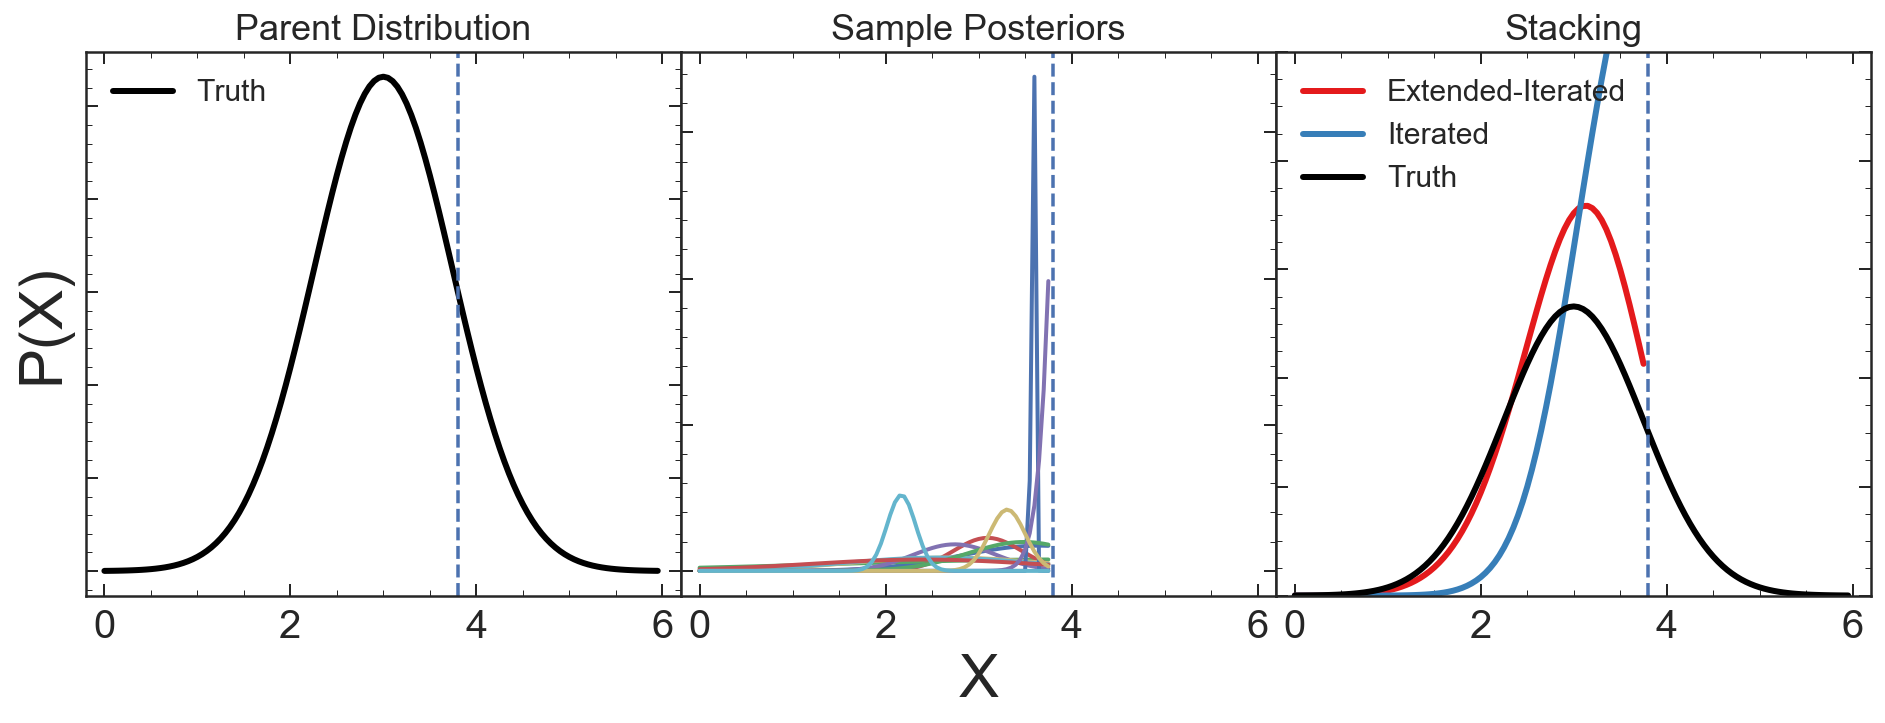

In [182]:
### PLOT
%matplotlib inline

gs = gridspec.GridSpec(1,3,wspace=0)

plt.figure(figsize=[16,5])
plt.subplot(gs[0])
plt.plot(x,gdist,'k',label='Truth',lw=3)
plt.legend(loc=2,fontsize=15)
plt.gca().tick_params(axis='y',labelleft='off')
plt.ylabel('P(X)',fontsize=30)
plt.axvline(lim,linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Parent Distribution', fontsize =18)
plt.xlim(-0.2,6.2)

plt.subplot(gs[1])
for i in range(sp_size):
    plt.plot(redx,dist_grid[i],lw=2)
plt.gca().tick_params(axis='y',labelleft='off')
plt.xlabel('X',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Sample Posteriors', fontsize =18)
plt.axvline(lim,linestyle='--')
plt.xlim(-0.2,6.2)

plt.subplot(gs[2])
plt.plot(redx,iterpos1,color='#e41a1c',label = 'Extended-Iterated',lw=3)
plt.plot(redx,iterpos2,color='#377eb8',label = 'Iterated',lw=3)
plt.plot(x,gdist,'k',label = 'Truth',lw=3)

plt.title('Stacking', fontsize =18)
plt.ylim(0,1.)
plt.gca().tick_params(axis='y',labelleft='off')
plt.legend(loc=2,fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.axvline(lim,linestyle='--')
plt.xlim(-0.2,6.2)

plt.savefig('../plots/stacking_exam_ext.png',bbox_inches = 'tight')


In [183]:
### DATA
np.random.seed(253)
x=np.arange(0.001,6,0.05)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12
lim = 6
redx = np.arange(0.001,lim,.05)
dist_grid= np.zeros([sp_size,redx.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(redx,np.random.normal(3,0.75),np.random.normal(0,0.75))

In [184]:
iterpos1,wstk1= Iterative_stacking(dist_grid,redx,extend=False,iterations=20,resampling=250)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


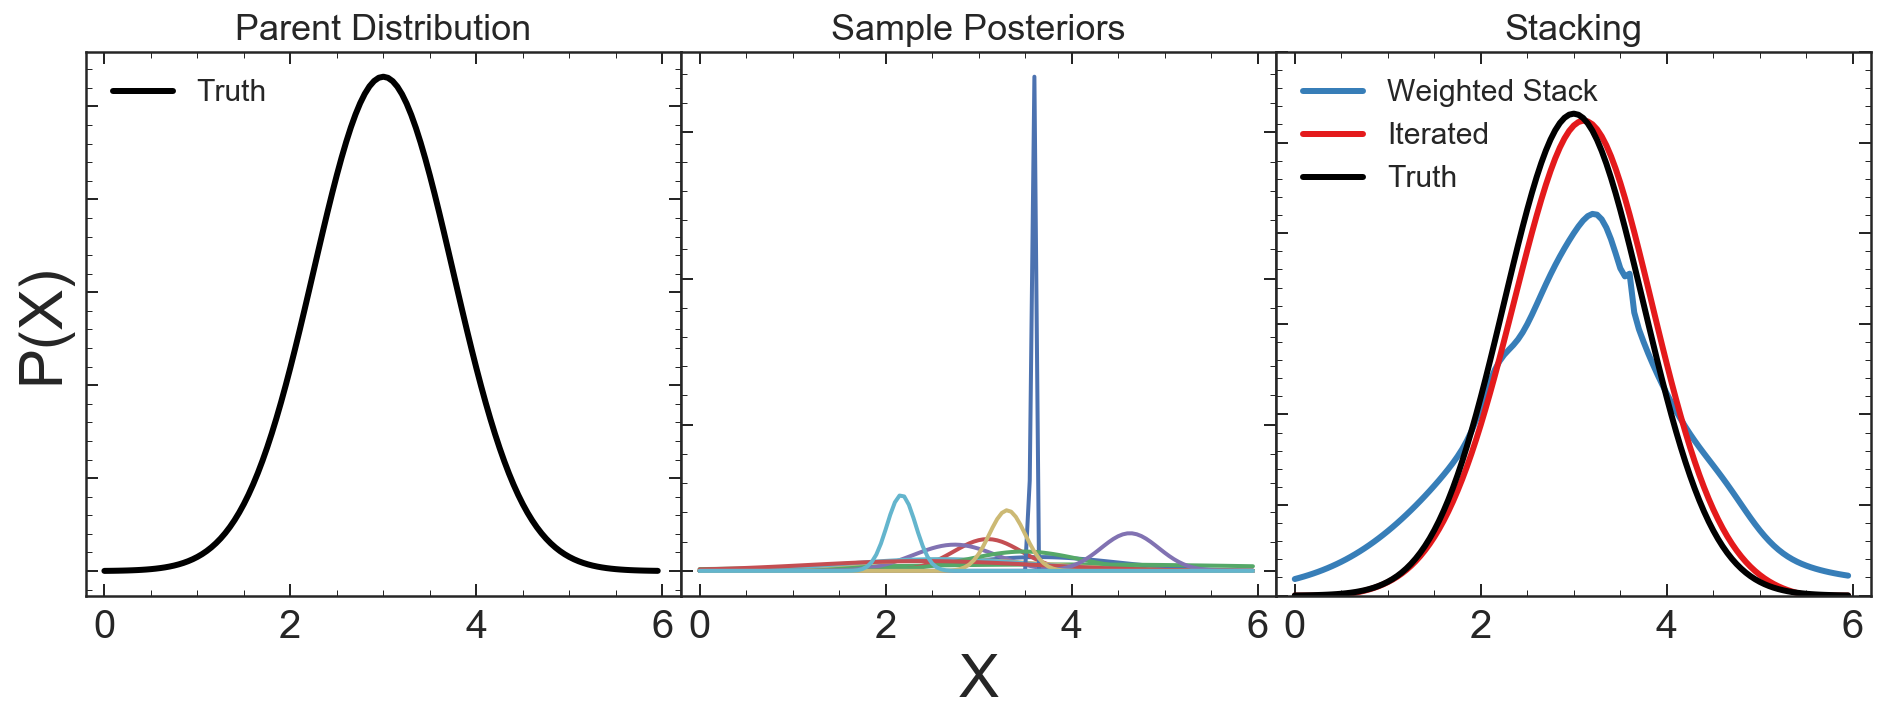

In [185]:
### PLOT
%matplotlib inline

gs = gridspec.GridSpec(1,3,wspace=0)

plt.figure(figsize=[16,5])
plt.subplot(gs[0])
plt.plot(x,gdist,'k',label='Truth',lw=3)
plt.legend(loc=2,fontsize=15)
plt.gca().tick_params(axis='y',labelleft='off')
plt.ylabel('P(X)',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Parent Distribution', fontsize =18)
plt.xlim(-0.2,6.2)

plt.subplot(gs[1])
for i in range(sp_size):
    plt.plot(redx,dist_grid[i],lw=2)
plt.gca().tick_params(axis='y',labelleft='off')
plt.xlabel('X',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Sample Posteriors', fontsize =18)
plt.xlim(-0.2,6.2)

plt.subplot(gs[2])
plt.plot(redx,wstk1,color='#377eb8',label = 'Weighted Stack',lw=3)
plt.plot(redx,iterpos1,color='#e41a1c',label = 'Iterated',lw=3)
plt.plot(x,gdist,'k',label = 'Truth',lw=3)
plt.title('Stacking', fontsize =18)
plt.ylim(0,.6)
plt.gca().tick_params(axis='y',labelleft='off')
plt.legend(loc=2,fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(-0.2,6.2)

plt.savefig('../plots/stacking_exam.png',bbox_inches = 'tight')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Vince.ec/GitHub/Quiescent_analysis/scripts/spec_id.py:42: RuntimeWarning: invalid value encountered in true_divide
  G /= C
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in rlbin(x, y, gpoints, truncate) : 
  NA/NaN/Inf in foreign function call (arg 2)

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in rlbin(x, y, gpoints, truncate) : 
  NA/NaN/Inf in foreign function call (arg 2)


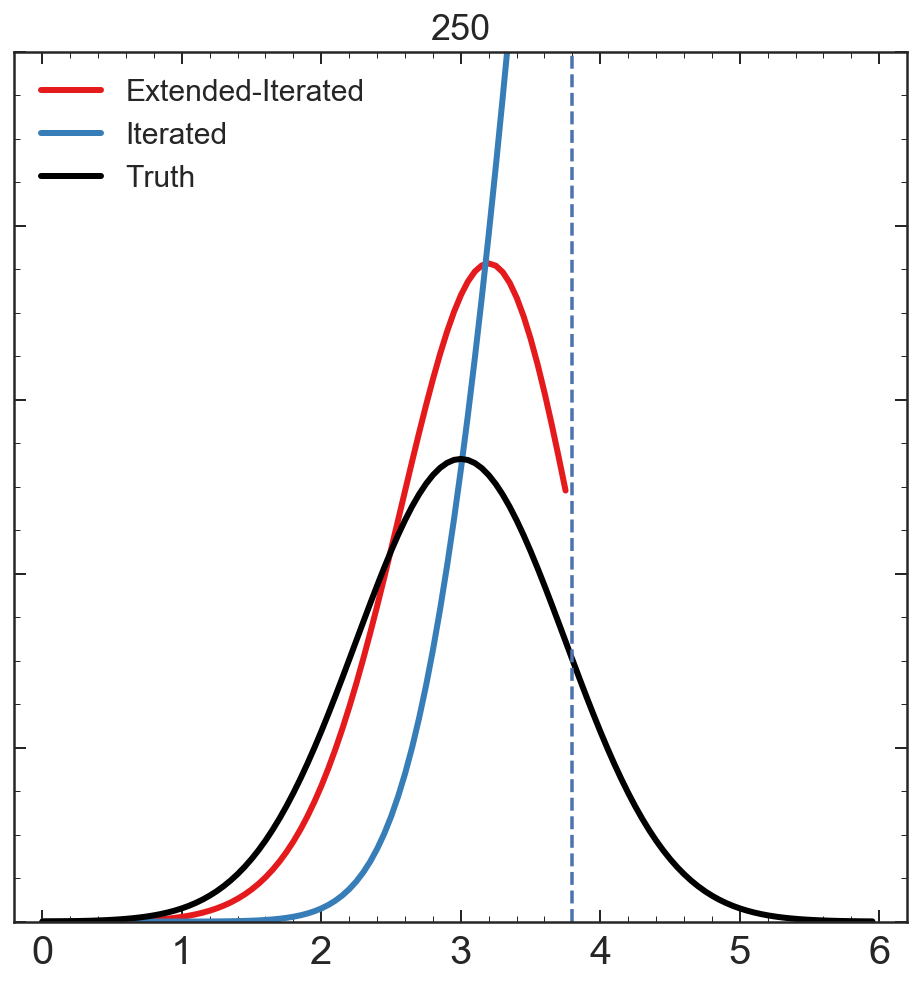

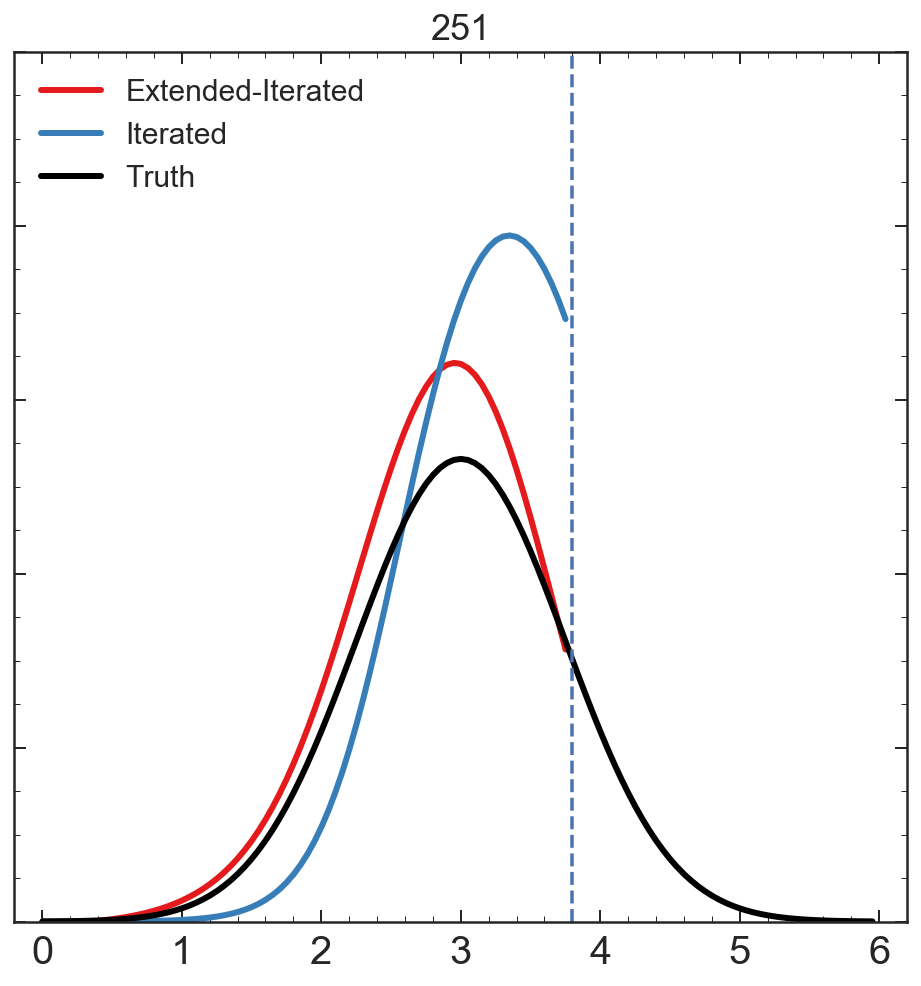

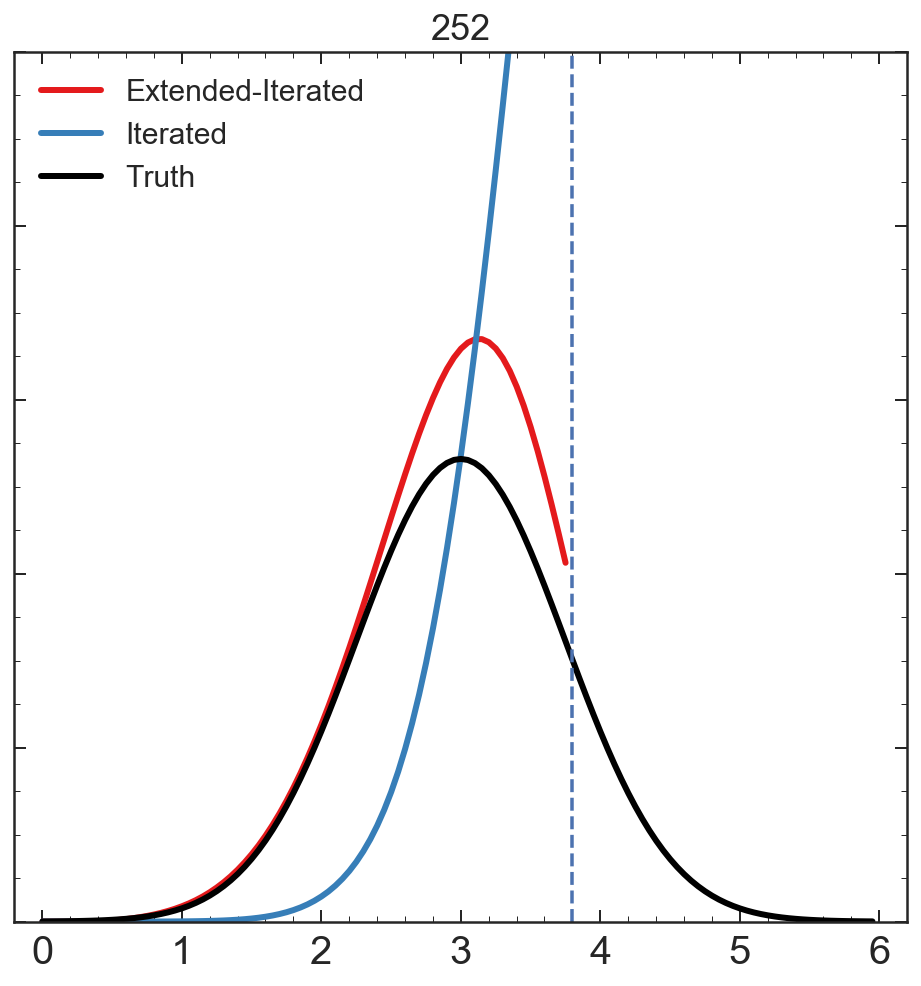

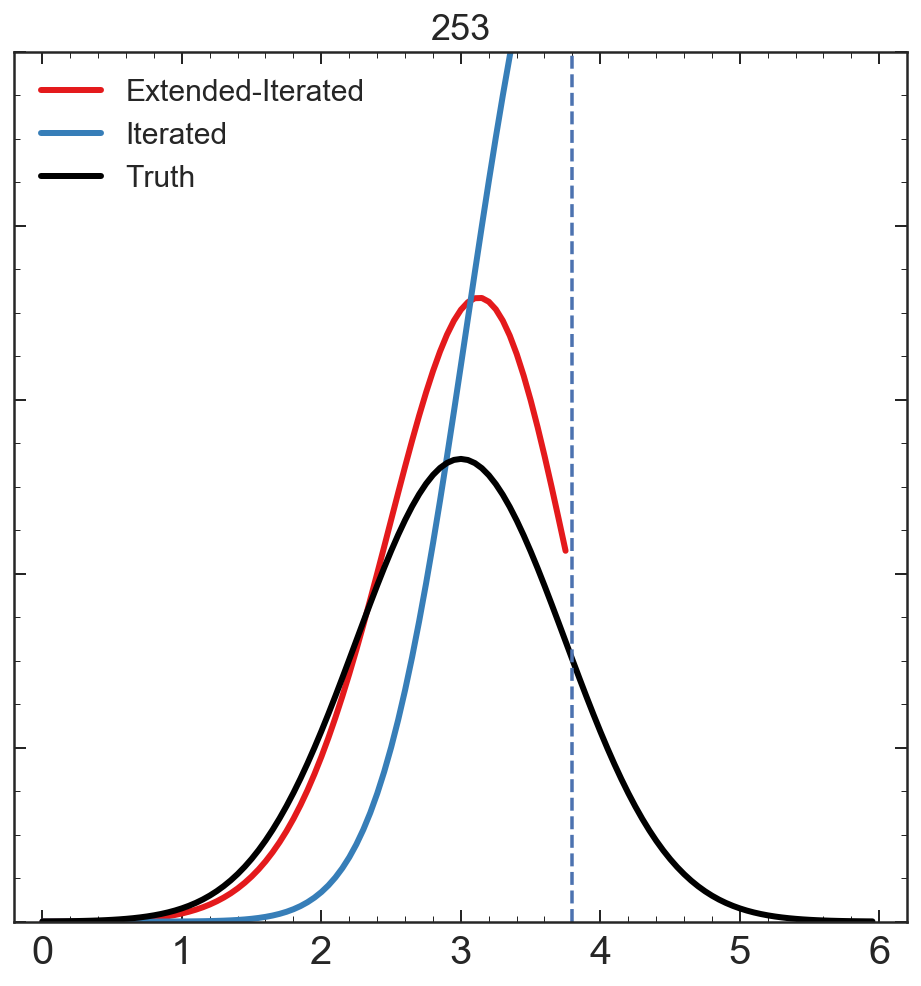

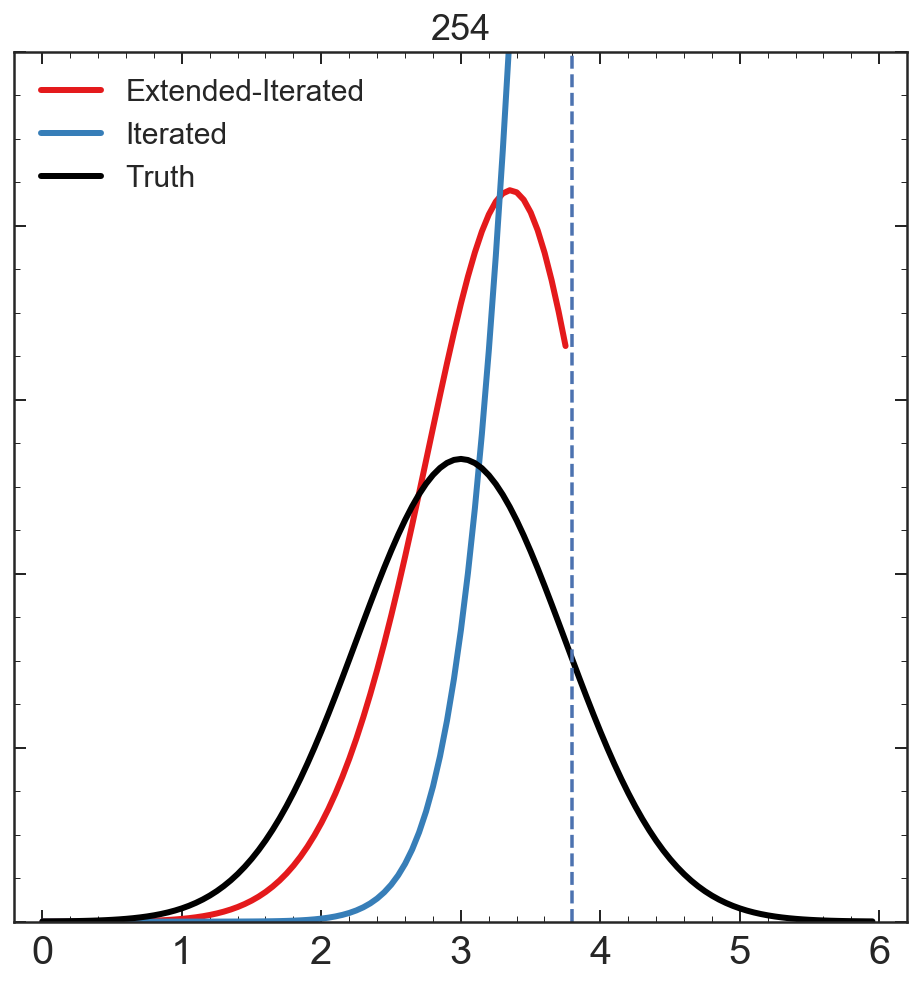

In [171]:
### DATA
for u in np.arange(250,270):
    np.random.seed(u)
    x=np.arange(0.001,6,0.05)
    ers = np.arange(0,1.5,0.001)
    gdist = Gauss_dist(x,3,.75)
    sp_size = 12
    lim = 3.8
    redx = np.arange(0.001,lim,.05)
    dist_grid= np.zeros([sp_size,redx.size])
    for i in range(sp_size):
        dist_grid[i] = Gauss_dist(redx,np.random.normal(3,0.75),np.random.normal(0,0.75))

    iterpos1,wstk1= Iterative_stacking(dist_grid,redx,extend=True,iterations=20,resampling=250)
    iterpos2,wstk2= Iterative_stacking(dist_grid,redx,extend=False,iterations=20,resampling=250)

    plt.figure(figsize=[8,8])
    plt.plot(redx,iterpos1,color='#e41a1c',label = 'Extended-Iterated',lw=3)
    plt.plot(redx,iterpos2,color='#377eb8',label = 'Iterated',lw=3)
    plt.plot(x,gdist,'k',label = 'Truth',lw=3)
    plt.title(u, fontsize =18)
    plt.ylim(0,1.)
    plt.gca().tick_params(axis='y',labelleft='off')
    plt.legend(loc=2,fontsize = 15)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.axvline(lim,linestyle='--')
    plt.xlim(-0.2,6.2)

In [97]:
### DATA

x=np.arange(0.001,6,0.001)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12

edges=[]
for u in range(100):
    try:
        o_dist_grid= np.zeros([sp_size,x.size])
        for ii in range(sp_size):
            o_dist_grid[ii] = Gauss_dist(x,np.random.normal(3,0.75),np.random.normal(0,1.5))

        lims = np.arange(3,5.1,.1)[::-1]
        for i in range(len(lims)):
            redx = np.arange(0.001,lims[i],.001)

            dist_grid= np.zeros([sp_size,redx.size])
            for ii in range(sp_size):
                C = np.trapz(o_dist_grid[ii][x < lims[i]] / redx)
                dist_grid[ii] = o_dist_grid[ii][x < lims[i]] / C

            iterpos1,wstk1= Iterative_stacking(dist_grid,redx,extend=True,iterations=20,resampling=250)
            iterpos2,wstk2= Iterative_stacking(dist_grid,redx,extend=False,iterations=20,resampling=250)

            if redx[iterpos2 == max(iterpos2)] == max(redx):
                edges.append(np.trapz(gdist[x<(lims[i])],redx))
                break
    except:
        print('skip')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in rlbin(x, y, gpoints, truncate) : 
  NA/NaN/Inf in foreign function call (arg 2)

  warnings.warn(x, RRuntimeWarning)


skip


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


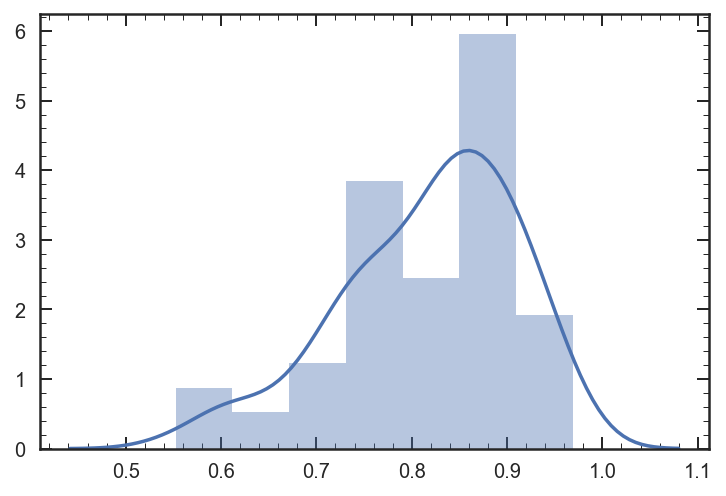

In [98]:
sea.distplot(edges)